# Rush Yards Over/Under Classifier

Predicts whether an NFL running back will hit the **OVER** on his rush-yard prop bet using a walk-forward XGBoost classification pipeline.

### Pipeline Overview
| Step | Description |
|------|-------------|
| 1 | **Data Loading** — engineered feature CSVs (base stats, defense, PBP, YBC/YAC, spread) |
| 2 | **Data Cleaning** — normalize player names; build composite join keys |
| 3 | **Odds Ingestion** — fetch live prop lines from S3; parse nested bookmaker JSON |
| 4 | **Regression Signal** — load pre-trained `XGBRegressor` → predicted rush yards |
| 5 | **Meta-Features** — pred vs. line diff, line-relative ratios, weekly rankings, edge metrics |
| 6 | **Classification** — `XGBClassifier` with walk-forward validation (2024–2025) |
| 7 | **Backtesting** — flat-stake simulation with edge threshold; equity curve |
| 8 | **Visualization** — calibration curve, equity plots, per-player prediction charts |

**Target variable:** `hit_over` — 1 if the player's actual rush yards exceeded the bookmaker's line, else 0.

In [1]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

## 1. Environment Setup

Add the repository root to `sys.path` and import shared project utilities.

In [2]:
# -- Path setup --
# Walk up to the repo root so the shared `utils` module can be imported
# regardless of where the notebook is opened from.
import sys
from pathlib import Path

repo_root = Path.cwd().resolve().parents[1]
print(f"Adding {repo_root} to sys.path")
sys.path.append(str(repo_root))

import utils

Adding /home/mrmath/Documents/modeling2 to sys.path


## 2. Data Loading

Read each engineered feature CSV produced by the feature-engineering notebooks.  
These files contain rolling averages, delta features, and matchup statistics.

In [3]:
# -- Load engineered feature CSVs --
# Each file was produced by its corresponding feature_engineering notebook.
base_stats_df = pd.read_csv('/home/mrmath/sports_betting_empire/sports_betting_empire/americanfootball_nfl/player_rush_yards/modeling/feature_engineering/base_stats_feature_engineering.csv')

defense_stats_df = pd.read_csv('/home/mrmath/sports_betting_empire/sports_betting_empire/americanfootball_nfl/player_rush_yards/modeling/feature_engineering/defense_stats_feature_engineering.csv')

pbp_df = pd.read_csv('/home/mrmath/sports_betting_empire/sports_betting_empire/americanfootball_nfl/player_rush_yards/modeling/feature_engineering/play_by_play_feature_engineering.csv')

ybc_yac_df = pd.read_csv('/home/mrmath/sports_betting_empire/sports_betting_empire/americanfootball_nfl/player_rush_yards/modeling/feature_engineering/ybc_yac_feature_engineering.csv')

In [4]:
# -- Load spread / point-differential features --
spread_point_diff_df = pd.read_csv('/home/mrmath/sports_betting_empire/sports_betting_empire/americanfootball_nfl/player_rush_yards/modeling/feature_engineering/point_diff_spread_train.csv')

## 3. Data Cleaning

Normalize player names across all datasets so join keys are consistent.  
Generational suffixes (Jr., III, etc.) are stripped using a regex utility, then  
composite `player_key` and `team_key` columns are built for cross-table merges.

In [5]:
# -- Player name normalization utility --
# Generational suffixes (Jr., III, etc.) appear inconsistently across data
# sources; stripping them ensures player keys join correctly.
import re

def clean_player_name(name: str) -> str:
    """
    Remove generational suffixes from player names.

    Why this matters:
    - Player name keys must be consistent across datasets
    - Some sources include suffixes (e.g., "Jr.", "III")
    - Others omit them
    - Removing them prevents join mismatches and duplicate identities

    Handles:
    - Jr, Jr.
    - Sr, Sr.
    - II, III, IV, V, VI
    - Case-insensitive
    - Extra whitespace
    """

    if not isinstance(name, str):
        return name

    # Normalize whitespace
    name = name.strip()

    # Regex to remove suffix at end of string
    # \b ensures we only match whole suffix tokens
    suffix_pattern = r"\b(JR|SR|II|III|IV|V|VI)\.?$"

    # Remove suffix (case-insensitive)
    cleaned = re.sub(suffix_pattern, "", name, flags=re.IGNORECASE)

    # Remove any leftover trailing whitespace
    return cleaned.strip()

In [6]:
# -- Apply name normalization to each player column across all datasets --
base_stats_df['clean_player_name'] = base_stats_df['Player'].apply(clean_player_name)
pbp_df['clean_player_name']        = pbp_df['player'].apply(clean_player_name)
ybc_yac_df['clean_player_name']    = ybc_yac_df['Player'].apply(clean_player_name)

In [7]:
# -- Build player-level join keys: "CleanName_YYYY-MM-DD" --
# A composite key is used so that two players with the same name on
# different dates (or the same player on different dates) don't collide.
base_stats_df['player_key'] = base_stats_df['clean_player_name'] + "_" + base_stats_df['Date'].astype(str)
pbp_df['player_key']        = pbp_df['clean_player_name']        + "_" + pbp_df['Date'].astype(str)
ybc_yac_df['player_key']    = ybc_yac_df['clean_player_name']    + "_" + ybc_yac_df['Date'].astype(str)

## 4. Data Merging

Join all feature tables into a single modeling DataFrame using player and team keys.  
Left joins are used throughout to preserve all base-stats rows; unmatched rows fill with `NaN`.

In [8]:
# -- Merge player-level feature tables on composite player key --
# Left joins: keep every base-stats row; unmatched PBP/YBC rows → NaN features.
merged_df = pd.merge(base_stats_df, pbp_df,     on='player_key', how='left', suffixes=('_base', '_pbp'))
merged_df = pd.merge(merged_df,    ybc_yac_df,  on='player_key', how='left', suffixes=('', '_ybc_yac'))

In [9]:
# -- Build team-level join key for the spread / point-differential table --
spread_point_diff_df['team_key'] = spread_point_diff_df['team'] + "_" + spread_point_diff_df['date'].astype(str)

In [10]:
# -- Merge spread / point-differential features onto the player DataFrame --
merged_df['team_key'] = merged_df['Team'] + "_" + merged_df['Date'].astype(str)
merged_df = pd.merge(merged_df, spread_point_diff_df, on='team_key', how='left', suffixes=('', '_spread_point_diff'))

In [11]:
# -- Merge defensive stats onto the player DataFrame --
defense_stats_df['team_key'] = defense_stats_df['Team'] + "_" + defense_stats_df['Date'].astype(str)
final_df = pd.merge(merged_df, defense_stats_df, on='team_key', how='left', suffixes=('', '_defense'))

## 5. Season Assignment & Filtering

Parse dates and derive NFL season years.  
Then filter down to **2023+** seasons — the regression model was trained on pre-2023 data,  
so the classifier is only evaluated on post-training data to prevent leakage.

In [12]:
# -- Parse dates and derive NFL season year --
# NFL seasons straddle calendar years; games in Jan/Feb belong to the prior
# season (e.g., Jan 2024 → season 2023).  Months ≥ March start a new season.
final_df['Date']   = pd.to_datetime(final_df['Date'])
final_df['season'] = final_df['Date'].apply(lambda x: x.year if x.month >= 3 else x.year - 1)

In [13]:
# -- Filter to 2023+ seasons only --
# The regression model was trained on pre-2023 data, so we evaluate the
# classifier only on 2023 and later seasons to avoid training-set overlap.
final_df = final_df[final_df['season'] >= 2023]

## 6. Odds Data

Fetch player rush-yard prop lines and Over/Under prices from S3 (2023–2025).  
The raw data contains nested bookmaker JSON that is flattened into a player-per-row format,  
then merged onto the feature DataFrame using the same composite `player_key`.

In [14]:
# -- Fetch player rush-yard prop odds from S3 (2023-2025) --
odds_data = utils.fetch_odds_from_s3('americanfootball_nfl', 'player_rush_yards', 2023, 2025)

Fetching odds from s3://sports-betting-empire/americanfootball_nfl/player_rush_yards/odds/odds_apiamericanfootball_nfl_player_rush_yards_odds_season_2023.0.parquet
Fetching odds from s3://sports-betting-empire/americanfootball_nfl/player_rush_yards/odds/odds_apiamericanfootball_nfl_player_rush_yards_odds_season_2024.0.parquet
Fetching odds from s3://sports-betting-empire/americanfootball_nfl/player_rush_yards/odds/odds_apiamericanfootball_nfl_player_rush_yards_odds_season_2025.0.parquet


In [15]:
# -- Parse odds game date from UTC commence_time → US/Eastern date --
# Converting to Eastern ensures dates align with box-score dates.
odds_data['date'] = pd.to_datetime(odds_data['commence_time'], utc=True).dt.tz_convert('America/New_York').dt.date

In [16]:
# -- Debug: inspect raw bookmaker structure for a single game --
odds_data['bookmakers'][0]

array([{'key': 'draftkings', 'last_update': '2023-09-07T23:20:23Z', 'markets': array([{'key': 'player_rush_yds', 'last_update': '2023-09-07T23:19:09Z', 'outcomes': array([{'description': 'David Montgomery', 'name': 'Over', 'point': 53.5, 'price': 1.87},
                     {'description': 'David Montgomery', 'name': 'Under', 'point': 53.5, 'price': 1.87},
                     {'description': 'Isiah Pacheco', 'name': 'Over', 'point': 52.5, 'price': 1.87},
                     {'description': 'Isiah Pacheco', 'name': 'Under', 'point': 52.5, 'price': 1.87},
                     {'description': 'Jahmyr Gibbs', 'name': 'Over', 'point': 36.5, 'price': 1.8},
                     {'description': 'Jahmyr Gibbs', 'name': 'Under', 'point': 36.5, 'price': 1.95},
                     {'description': 'Jared Goff', 'name': 'Over', 'point': 3.5, 'price': 1.8},
                     {'description': 'Jared Goff', 'name': 'Under', 'point': 3.5, 'price': 1.95},
                     {'description': 'Jerick

In [17]:
# -- Parse nested odds JSON into a flat player-level DataFrame --
# Each row in odds_data contains a nested list of bookmakers → markets → outcomes.
# We extract the first bookmaker's first market (player rush yards) and pivot
# each player's Over/Under price into a single flat row per player per game.
clean_odds_df = pd.DataFrame()

for i in range(len(odds_data)):
    row = odds_data.iloc[i]
    date = row['date']

    # Skip games with no bookmaker or market data
    if len(row['bookmakers']) == 0 or len(row['bookmakers'][0]['markets']) == 0:
        continue

    data = row['bookmakers'][0]['markets'][0]['outcomes']
    new_row = {}

    for item in data:
        player_name = item['description']
        price       = item['price']
        line        = item['point']
        name        = item['name']  # 'Over' or 'Under'

        if player_name not in new_row:
            new_row[player_name] = {'player': player_name, 'line': line, 'date': date, f'{name}_price': price}
        else:
            new_row[player_name][f'{name}_price'] = price

    clean_odds_df = pd.concat([clean_odds_df, pd.DataFrame(list(new_row.values()))], ignore_index=True)

In [18]:
# -- Normalize odds player names (same suffix stripping as feature data) --
clean_odds_df['clean_player_name'] = clean_odds_df['player'].apply(clean_player_name)

In [19]:
# -- Debug: preview parsed odds table --
clean_odds_df

,player,line,date,Over_price,Under_price,clean_player_name
0,David Montgomery,53.5,2023-09-07,1.87,1.87,David Montgomery
1,Isiah Pacheco,52.5,2023-09-07,1.87,1.87,Isiah Pacheco
2,Jahmyr Gibbs,36.5,2023-09-07,1.80,1.95,Jahmyr Gibbs
3,Jared Goff,3.5,2023-09-07,1.80,1.95,Jared Goff
4,Jerick McKinnon,17.5,2023-09-07,1.91,1.83,Jerick McKinnon
...,...,...,...,...,...,...
3303,Brock Purdy,11.5,2025-12-28,1.85,1.94,Brock Purdy
3304,Bijan Robinson,74.5,2025-12-29,1.91,1.87,Bijan Robinson
3305,Kyren Williams,65.5,2025-12-29,1.87,1.91,Kyren Williams
3306,Blake Corum,47.5,2025-12-29,1.88,1.90,Blake Corum


In [20]:
# -- Build composite join key for odds table: "CleanName_YYYY-MM-DD" --
clean_odds_df['player_key'] = clean_odds_df['clean_player_name'] + "_" + clean_odds_df['date'].astype(str)

In [21]:
# -- Merge odds (line, Over/Under prices) onto the feature DataFrame --
# Left join keeps all player rows; players without odds will have NaN prices.
final_df = pd.merge(final_df, clean_odds_df[['player_key', 'line', 'Over_price', 'Under_price']], on='player_key', how='left')

In [22]:
# -- Drop rows without a prop line (no odds data available for that game) --
final_df = final_df.dropna(subset=['line'])

## 7. Regression Model Predictions

Load the regression model predictions (from `train_test_reg.ipynb`)
These predictions feed directly into the classifier as a meta-feature (`pred_vs_line_diff`).

In [23]:
pred_df = pd.read_csv('predictions_from_regression_model.csv')

In [24]:
final_df = pd.merge(final_df, pred_df[['player_key', 'predicted_rush_yards']], on='player_key', how='left')

## 8. Target Variable & Meta-Features

Define the binary classification target and engineer key meta-features:

| Feature | Description |
|---------|-------------|
| `pred_vs_line_diff` | Regressor prediction minus bookmaker line — signed model edge |
| `hit_over` | Ground truth: 1 if actual rush yards > line, else 0 |
| `line_over_*` | Line divided by rolling offensive/defensive averages — market ambition ratios |

In [25]:
# -- Derive target variable and key classifier meta-feature --
# pred_vs_line_diff: how many yards the regressor thinks the player beats
#   (or misses) the bookmaker's line — a signed measure of model edge.
# hit_over: binary ground truth (1 = actual yards exceeded the line).
final_df['pred_vs_line_diff'] = final_df['predicted_rush_yards'] - final_df['line']
final_df['hit_over']          = (final_df['Rush_yards'] > final_df['line']).astype(int)

In [26]:
# -- Debug: inspect all column names after merges --
final_df.columns.values

array(['Player', 'Team_base', 'Date_base', 'Att', 'Rush_yards', 'Starter',
       'rush_yards_1ma', 'rush_yards_3ma', 'rush_yards_5ma',
       'rush_yards_10ma', 'rush_yards_delta_3_5', 'rush_yards_delta_5_10',
       'rush_attempts_1ma', 'rush_attempts_3ma', 'rush_attempts_5ma',
       'rush_attempts_10ma', 'rush_attempts_delta_3_5',
       'rush_attempts_delta_5_10', 'ypc_1ma', 'ypc_3ma', 'ypc_5ma',
       'ypc_10ma', 'ypc_delta_3_5', 'ypc_delta_5_10', 'success_rate_1ma',
       'success_rate_3ma', 'success_rate_5ma', 'success_rate_10ma',
       'success_rate_delta_3_5', 'rush_yards_vol_5', 'ypc_vol_5',
       'min_rush_yards_3ma', 'min_rush_yards_5ma', 'max_rush_yards_3ma',
       'max_rush_yards_5ma', 'Pos.', 'others_rush_attempts_1ma',
       'others_rush_attempts_3ma', 'others_rush_attempts_5ma',
       'pct_of_carries_1ma', 'pct_of_carries_3ma', 'pct_of_carries_5ma',
       'others_been_injured_1ma', 'others_been_injured_3ma',
       'others_been_injured_5ma', 'carries_before_in

## 9. Line-Relative Ratio Features

Divide the bookmaker's prop line by recent offensive and defensive rolling averages.  
These ratios capture how "ambitious" the line is relative to recent on-field performance —  
a high ratio suggests the line may be overestimating the player or the matchup difficulty.

In [27]:
# -- Line-relative meta-features --
# Dividing the bookmaker's line by rolling averages produces a normalized
# ratio that captures how ambitious the line is relative to recent form.
# A small epsilon (1e-5) prevents division-by-zero on zero-carry games.

# How inflated is the line vs. recent rush-attempt volume?
final_df['line_over_rush_attempts_3_ma'] = final_df['line'] / (final_df['rush_attempts_3ma'] + 1e-5)

In [28]:
# How ambitious is the line vs. recent yards-per-carry efficiency?
final_df['line_over_ypc_3_ma'] = final_df['line'] / (final_df['ypc_3ma'] + 1e-5)

In [29]:
# How ambitious is the line vs. yards the defense has recently allowed to RBs?
final_df['line_over_rush_yards_allowed_3_ma'] = final_df['line'] / (final_df['RB_rush_yards_allowed_3ma'] + 1e-5)

In [30]:
# How ambitious is the line vs. YPC the defense has allowed to RBs?
final_df['line_over_ypc_allowed_3_ma'] = final_df['line'] / (final_df['RB_ypc_allowed_3ma'] + 1e-5)

## 10. Within-Week Rankings & Edge Metrics

Rank each player's rolling stats as a percentile within their season-week cohort.  
This removes cross-season scale drift and lets the model think in relative terms  
(e.g., _"top-10% rusher facing a bottom-20% rush defense"_).

Edge metrics combine offensive and defensive rank percentiles to capture matchup favorability:

In [31]:
# -- Within-week percentile rankings --
# Ranking each player's rolling stats within their season-week cohort removes
# cross-season scale drift and lets the model reason in relative rather than
# absolute terms (e.g., "top 10% rusher this week vs. a bottom-20% defense").

# RB offensive rank (higher rush yards → better rank, pct ascending=False)
final_df['rush_yards_5ma_rank'] = (
    final_df
    .groupby(['season', 'Week'])['rush_yards_5ma']
    .rank(pct=True, method='min', ascending=False)
)
final_df['rush_yards_3ma_rank'] = (
    final_df
    .groupby(['season', 'Week'])['rush_yards_3ma']
    .rank(pct=True, method='min', ascending=False)
)

# Defense rank: more yards allowed = worse defense → ascending=True so rank 1.0
# means the defense gives up the most yards (easiest matchup)
final_df['rb_rush_yards_allowed_5ma_rank'] = (
    final_df
    .groupby(['season', 'Week'])['RB_rush_yards_allowed_5ma']
    .rank(pct=True, method='min', ascending=True)
)
final_df['rb_rush_yards_allowed_3ma_rank'] = (
    final_df
    .groupby(['season', 'Week'])['RB_rush_yards_allowed_3ma']
    .rank(pct=True, method='min', ascending=True)
)

In [32]:
# -- Within-week prop-line rank --
# A high line rank means the bookmaker has set one of the more ambitious lines
# this week; combining with the RB's offensive rank captures whether the market
# has priced the matchup correctly.
final_df['line_rank'] = (
    final_df
    .groupby(['season', 'Week'])['line']
    .rank(pct=True, method='min', ascending=False)
)

In [33]:
# -- Edge metrics: RB vs. defense and RB vs. line --
# Positive values indicate a favorable matchup (elite RB vs. weak defense or
# vs. a line that may underestimate the player's ability).
# These features let the model learn non-linear interactions between the
# offensive and defensive rank percentiles without manual binning.

final_df['rb_vs_defense_edge_5ma'] = (
    final_df['rush_yards_5ma_rank']
    - final_df['rb_rush_yards_allowed_5ma_rank']
)
final_df['rb_vs_defense_edge_3ma'] = (
    final_df['rush_yards_3ma_rank']
    - final_df['rb_rush_yards_allowed_3ma_rank']
)

# Duplicate removed — keeping single definitive assignment
final_df['rb_vs_defense_edge_3ma'] = (
    final_df['rush_yards_3ma_rank']
    - final_df['rb_rush_yards_allowed_3ma_rank']
)

# How much does the RB's offensive rank exceed the implied demand of the line?
final_df['rb_vs_line_edge_5ma'] = (
    final_df['rush_yards_5ma_rank']
    - final_df['line_rank']
)

In [34]:
# -- Debug: verify all new feature columns are present --
final_df.columns.values

array(['Player', 'Team_base', 'Date_base', 'Att', 'Rush_yards', 'Starter',
       'rush_yards_1ma', 'rush_yards_3ma', 'rush_yards_5ma',
       'rush_yards_10ma', 'rush_yards_delta_3_5', 'rush_yards_delta_5_10',
       'rush_attempts_1ma', 'rush_attempts_3ma', 'rush_attempts_5ma',
       'rush_attempts_10ma', 'rush_attempts_delta_3_5',
       'rush_attempts_delta_5_10', 'ypc_1ma', 'ypc_3ma', 'ypc_5ma',
       'ypc_10ma', 'ypc_delta_3_5', 'ypc_delta_5_10', 'success_rate_1ma',
       'success_rate_3ma', 'success_rate_5ma', 'success_rate_10ma',
       'success_rate_delta_3_5', 'rush_yards_vol_5', 'ypc_vol_5',
       'min_rush_yards_3ma', 'min_rush_yards_5ma', 'max_rush_yards_3ma',
       'max_rush_yards_5ma', 'Pos.', 'others_rush_attempts_1ma',
       'others_rush_attempts_3ma', 'others_rush_attempts_5ma',
       'pct_of_carries_1ma', 'pct_of_carries_3ma', 'pct_of_carries_5ma',
       'others_been_injured_1ma', 'others_been_injured_3ma',
       'others_been_injured_5ma', 'carries_before_in

In [35]:
# -- Matchup point-differential feature --
# Captures the "game script" imbalance: a team facing a strong opponent
# (negative differential) is less likely to run the ball on late downs,
# which hurts RB rush-yard totals.
final_df['team_opp_point_diff_5_sum'] = final_df['opp_point_diff_5_sum'] - final_df['point_diff_5_sum']

## 11. Final Feature List

Consolidate the classifier's training columns.  
Each feature was selected to capture a distinct signal dimension:

| Category | Features |
|----------|----------|
| Regressor signal | `pred_vs_line_diff` |
| Market context | `spread` |
| Line-relative ratios | `line_over_rush_attempts_3_ma`, `line_over_ypc_3_ma`, `line_over_rush_yards_allowed_3_ma`, `line_over_ypc_allowed_3_ma` |
| Play-style tendencies | `opponent_rushes_one_to_two_5ma`, `team_rushes_less_than_eq_zero_3ma` |
| Matchup edge | `rb_vs_defense_edge_5ma`, `rb_vs_defense_edge_3ma`, `rb_vs_line_edge_5ma` |
| Game script | `team_opp_point_diff_5_sum` |

In [36]:
# -- Final training feature list for the classifier --
# Columns chosen to capture:
#   - Regressor signal (pred_vs_line_diff)
#   - Market context (spread)
#   - Line-relative efficiency ratios (line_over_*)
#   - Play-style tendencies (short-yardage rush rates from PBP)
#   - Matchup edge metrics (rb_vs_defense, rb_vs_line)
#   - Momentum / game-script context (team_opp_point_diff_5_sum)
train_cols = [
    'pred_vs_line_diff',
    'spread',
    'line_over_rush_attempts_3_ma',
    'line_over_ypc_3_ma',
    'line_over_rush_yards_allowed_3_ma',
    'line_over_ypc_allowed_3_ma',
    'opponent_rushes_one_to_two_5ma',
    'team_rushes_less_than_eq_zero_3ma',
    'rb_vs_defense_edge_5ma',
    'rb_vs_defense_edge_3ma',
    'rb_vs_line_edge_5ma',
    'team_opp_point_diff_5_sum',
]

## 12. Feature Correlation Analysis

Compute **Spearman rank correlation** between candidate features and the `hit_over` target.  
Spearman is preferred here because it captures monotonic (not just linear) relationships,  
which is more appropriate for bounded rolling averages and ratio features.

In [37]:
# -- Select columns for Spearman correlation analysis --
# Inspect which rolling and meta features are most monotonically correlated
# with hitting the over (hit_over). Useful for feature selection.
cols = (
    [c for c in final_df.columns
     if c.endswith('_3ma') or c.endswith('_5ma')
     or c.endswith('_3_sum') or c.endswith('_5_sum')
     or c.endswith('_3_ma')]
    + ['spread', 'pred_vs_line_diff', 'predicted_rush_yards']
)

In [38]:
# -- Spearman correlation of features vs. hit_over target --
# Spearman is rank-based so it captures monotonic (not just linear) relationships;
# better suited for bounded rolling averages and ratio features.
final_df[cols + ['hit_over']].corr(method='spearman')['hit_over'].sort_values()

rb_vs_defense_edge_5ma              -0.074806
spread                              -0.065631
opp_point_diff_5_sum                -0.058692
opponent_rushes_one_to_two_5ma      -0.053175
team_rushes_less_than_eq_zero_3ma   -0.049214
                                       ...   
defense_performance_relative_5ma     0.062968
total_diff_3ma                       0.064752
predicted_rush_yards                 0.074632
pred_vs_line_diff                    0.104131
hit_over                             1.000000
Name: hit_over, Length: 142, dtype: float64

## 13. Walk-Forward Classification Model

Train an `XGBClassifier` using a strict walk-forward split: train on all seasons  
before the target season, test on the target season only.  
This mirrors live deployment where the model is retrained each season before predictions.

**Hyperparameter choices to combat overfitting on a small dataset:**
- `max_depth=3` — shallow trees prevent memorization  
- `min_child_weight=10` — requires ≥10 samples per leaf  
- `n_estimators=200` combined with `learning_rate=0.01` — slow, conservative learning

In [39]:
# -- Walk-forward XGBClassifier training and evaluation --
# Strategy: for each target season, train on all prior seasons and test on
# the target season.  This mimics live deployment where the model is retrained
# each season before making predictions — no future data leaks into training.
#
# Hyperparameters chosen to combat overfitting on a small dataset:
#   max_depth=3        → shallow trees prevent memorization
#   min_child_weight=10 → requires at least 10 samples per leaf
#   n_estimators=200   → enough iterations for low learning_rate=0.01
import xgboost as xgb
from sklearn.metrics import roc_auc_score

final_df = final_df.sort_values('Date')

class_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.01,
    random_state=42,
    min_child_weight=10,
)

all_preds = []

for season in range(2024, 2026):
    train_data = final_df[final_df['season'] < season]
    test_data  = final_df[final_df['season'] == season]

    X_train = train_data[train_cols]
    y_train = train_data['hit_over']
    X_test  = test_data[train_cols]
    y_test  = test_data['hit_over']

    # Fit on all seasons before the target season
    class_model.fit(X_train, y_train)

    # Predict calibrated probabilities for the Over (class 1)
    predictions = class_model.predict_proba(X_test)[:, 1]
    X_test = X_test.copy()

    test_data = test_data.copy()
    test_data.loc[:, 'proba_over'] = predictions
    test_data.loc[:, 'hit_over']   = y_test
    all_preds.append(test_data)

    print(
        f"Season {season} - "
        f"ROC AUC: {roc_auc_score(y_test, predictions):.4f}"
    )

Season 2024 - ROC AUC: 0.5781
Season 2025 - ROC AUC: 0.5479


In [40]:
# -- Combine walk-forward predictions for all seasons into one DataFrame --
all_pred_df = pd.concat(all_preds, ignore_index=True)

## 14. Model Evaluation

Assess model quality from two angles:
1. **Calibration curve** — are predicted probabilities reliable? A well-calibrated model's curve should track the diagonal.  
2. **Probability distribution** — does the model produce a useful spread of predictions, or does it cluster near 50%?

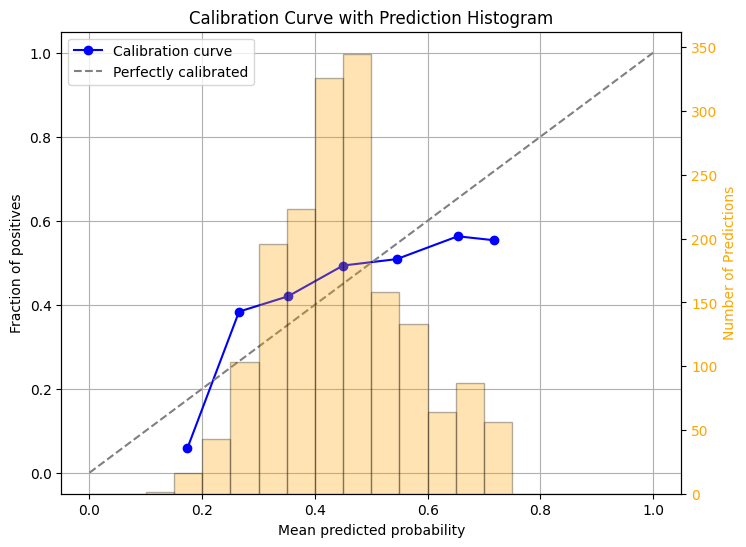

In [41]:
# -- Calibration curve: are predicted probabilities reliable? --
# A well-calibrated model should have its calibration curve close to the
# diagonal.  The histogram on the secondary axis shows prediction spread —
# a model that only predicts near 0.5 is not useful for edge betting.
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

df = all_pred_df.dropna(subset=['hit_over', 'proba_over'])
prob_true, prob_pred = calibration_curve(df['hit_over'], df['proba_over'], n_bins=10)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Calibration curve
ax1.plot(prob_pred, prob_true, marker='o', label='Calibration curve', color='blue')
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
ax1.set_xlabel('Mean predicted probability')
ax1.set_ylabel('Fraction of positives')
ax1.set_title('Calibration Curve with Prediction Histogram')
ax1.legend(loc='upper left')
ax1.grid(True)

# Histogram on secondary y-axis (distribution of model outputs)
ax2 = ax1.twinx()
ax2.hist(df['proba_over'], bins=20, range=(0, 1), alpha=0.3, color='orange', edgecolor='black')
ax2.set_ylabel('Number of Predictions', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.show()

In [42]:
# -- Sanity check: hit rate when the model's Under confidence is high (< 40%) --
# If the model is calibrated, this bucket should have a low hit_over rate.
all_pred_df[all_pred_df['proba_over'] < 0.4][['proba_over', 'hit_over']]['hit_over'].value_counts()

hit_over
0    349
1    233
Name: count, dtype: int64

In [43]:
# -- Debug: confirm Over/Under decimal prices are present --
all_pred_df[['Over_price', 'Under_price']]

,Over_price,Under_price
0,1.87,1.87
1,1.87,1.87
2,1.83,1.91
3,1.91,1.83
4,1.95,1.80
...,...,...
1746,1.90,1.88
1747,1.88,1.90
1748,1.91,1.87
1749,1.85,1.93


## 15. Backtesting

Simulate a flat-stake betting strategy on the held-out test seasons.

**Rules:**
- Bet **1 unit** on any side (Over or Under) where the model's edge exceeds `EDGE_THRESHOLD = 3%`  
- Edge = model probability − implied probability (1 / decimal odds)  
- P&L: win → `stake × (odds − 1)`, lose → `-stake`

Then plot equity curves both by **bet number** and by **calendar date** to assess consistency.

In [44]:
# -- Compute implied probabilities and model edges for backtesting --
# Implied probability = 1 / decimal_odds  (ignores vig for simplicity).
# Edge = model probability - implied probability.
# A positive edge means the model thinks the outcome is more likely than
# the bookmaker does — the fundamental signal for value betting.
df_bt = all_pred_df.sort_values('date').copy()

df_bt['over_implied_prob']  = 1 / df_bt['Over_price']
df_bt['under_implied_prob'] = 1 / df_bt['Under_price']
df_bt['under_model_prob']   = 1 - df_bt['proba_over']
df_bt['over_edge']          = df_bt['proba_over']       - df_bt['over_implied_prob']
df_bt['under_edge']         = df_bt['under_model_prob'] - df_bt['under_implied_prob']

In [45]:
# -- Flat-stake backtesting loop --
# Bet 1 unit on any side where the model's edge exceeds EDGE_THRESHOLD.
# Profit/loss follows decimal odds: win → stake * (odds - 1), lose → -stake.
EDGE_THRESHOLD = 0.03  # minimum required model edge (3%) to place a bet

df_bt['bet'] = None
df_bt.loc[df_bt['over_edge']  > EDGE_THRESHOLD, 'bet'] = 'over'
df_bt.loc[df_bt['under_edge'] > EDGE_THRESHOLD, 'bet'] = 'under'

# Keep only rows where a bet is placed
df_bt = df_bt[df_bt['bet'].notnull()].copy()

profits = []

for _, row in df_bt.iterrows():
    stake = 1.0

    if row['bet'] == 'over':
        win  = row['hit_over'] == 1
        odds = row['Over_price']
    else:
        win  = row['hit_over'] == 0
        odds = row['Under_price']

    # Decimal-odds P&L
    if win:
        profit = stake * (odds - 1)
    else:
        profit = -stake

    profits.append(profit)

df_bt['profit']     = profits
df_bt['cum_profit'] = df_bt['profit'].cumsum()

In [46]:
# -- Print backtest summary statistics --
# ROI = total profit / number of bets (1 unit per bet).
# Win rate = share of bets that returned a profit.
total_bets   = len(df_bt)
total_profit = df_bt['profit'].sum()
roi          = total_profit / total_bets if total_bets > 0 else 0
win_rate     = (df_bt['profit'] > 0).mean()

print("Total Bets:",          total_bets)
print("Total Profit (units):", round(total_profit, 2))
print("ROI:",                  round(roi * 100, 2), "%")
print("Win Rate:",             round(win_rate * 100, 2), "%")

Total Bets: 1163
Total Profit (units): 67.02
ROI: 5.76 %
Win Rate: 56.32 %


In [47]:
# -- Recompute cumulative profit (ensures correct ordering after any reindex) --
df_bt['cum_profit'] = df_bt['profit'].cumsum()

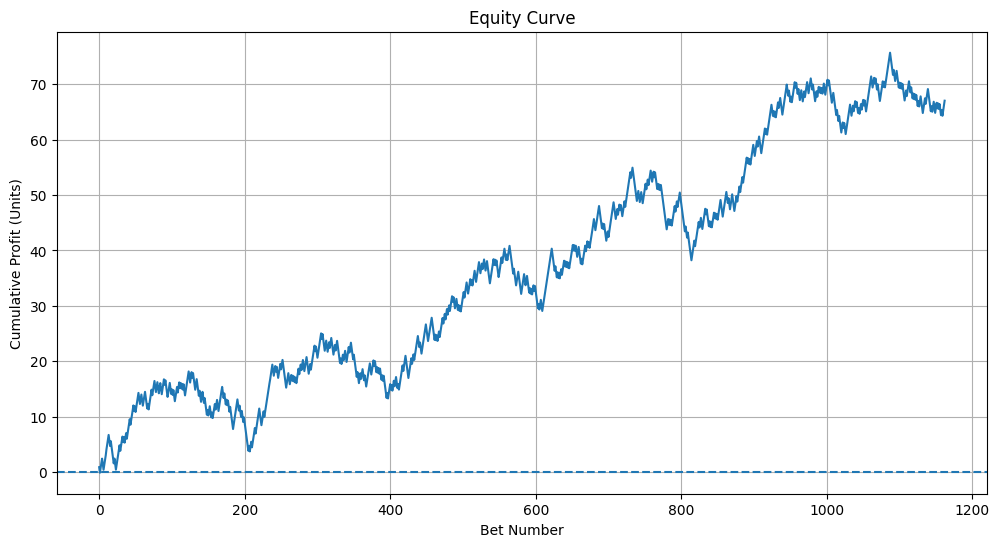

In [48]:
# -- Equity curve: cumulative profit by bet number --
# A steadily rising curve indicates consistent edge; drawdown periods show
# variance inherent in sports betting.
df_bt = df_bt.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(df_bt.index, df_bt['cum_profit'])
plt.axhline(0, linestyle='--')
plt.xlabel("Bet Number")
plt.ylabel("Cumulative Profit (Units)")
plt.title("Equity Curve")
plt.grid(True)
plt.show()

In [49]:
# -- Build daily-aggregated equity series --
# Grouping by date smooths out same-day bet ordering variance and makes
# the equity curve easier to read on a timeline.
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_bt['date'] = pd.to_datetime(df_bt['date'])

daily = (
    df_bt
    .groupby('date')['profit']
    .sum()
    .cumsum()
    .reset_index(name='cum_profit')
)

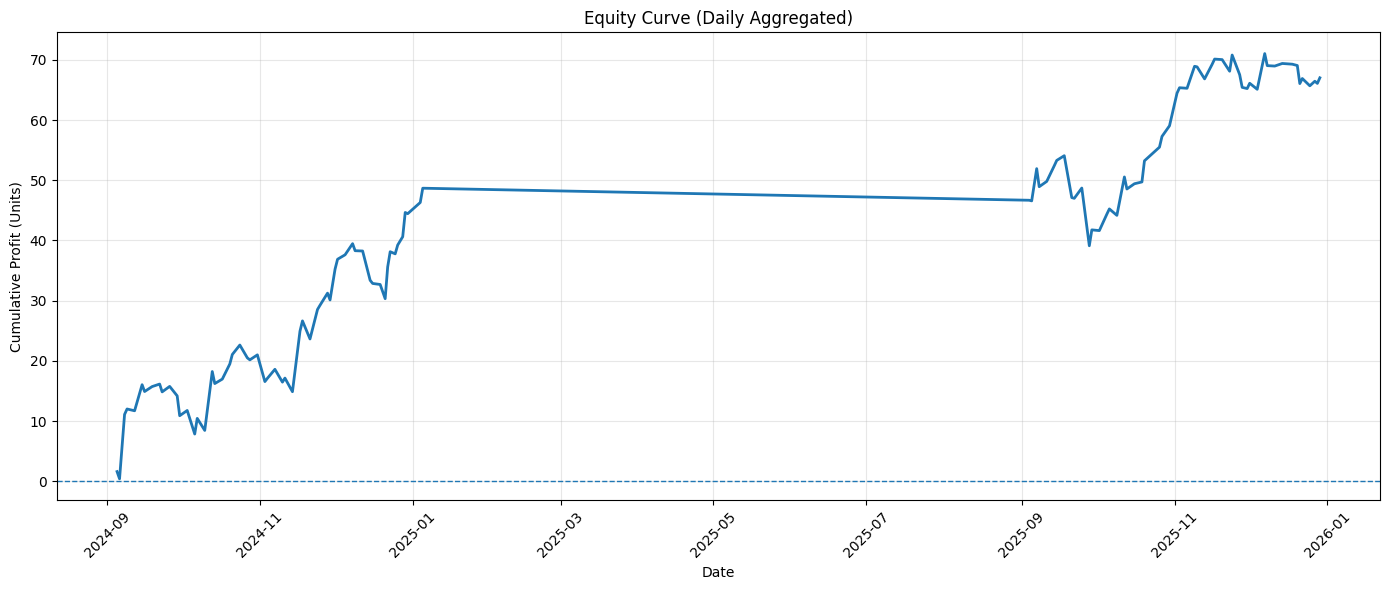

In [50]:
# -- Plot daily-aggregated equity curve --
plt.figure(figsize=(14, 6))

plt.plot(daily['date'], daily['cum_profit'], linewidth=2)
plt.axhline(0, linestyle='--', linewidth=1)

plt.xlabel("Date")
plt.ylabel("Cumulative Profit (Units)")
plt.title("Equity Curve (Daily Aggregated)")

# Space x-axis ticks every 2 months for readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [51]:
# -- Debug: inspect proba_over values for the last test season --
test_data['proba_over']

1235    0.584890
1234    0.235216
1239    0.493030
1238    0.460800
1237    0.424170
          ...   
2061    0.433751
2091    0.480295
2089    0.453028
2090    0.388234
2092    0.490973
Name: proba_over, Length: 859, dtype: float32

## 16. Per-Player Visualization

Generate two-panel charts for selected players in the 2025 season:

- **Panel 1:** Actual vs. predicted rush yards with the bookmaker line overlaid. Annotated with MAE and RMSE.  
- **Panel 2:** Model Over-probability bars, color-coded green (correct call) / red (incorrect call). Annotated with accuracy and Over/Under breakdown.

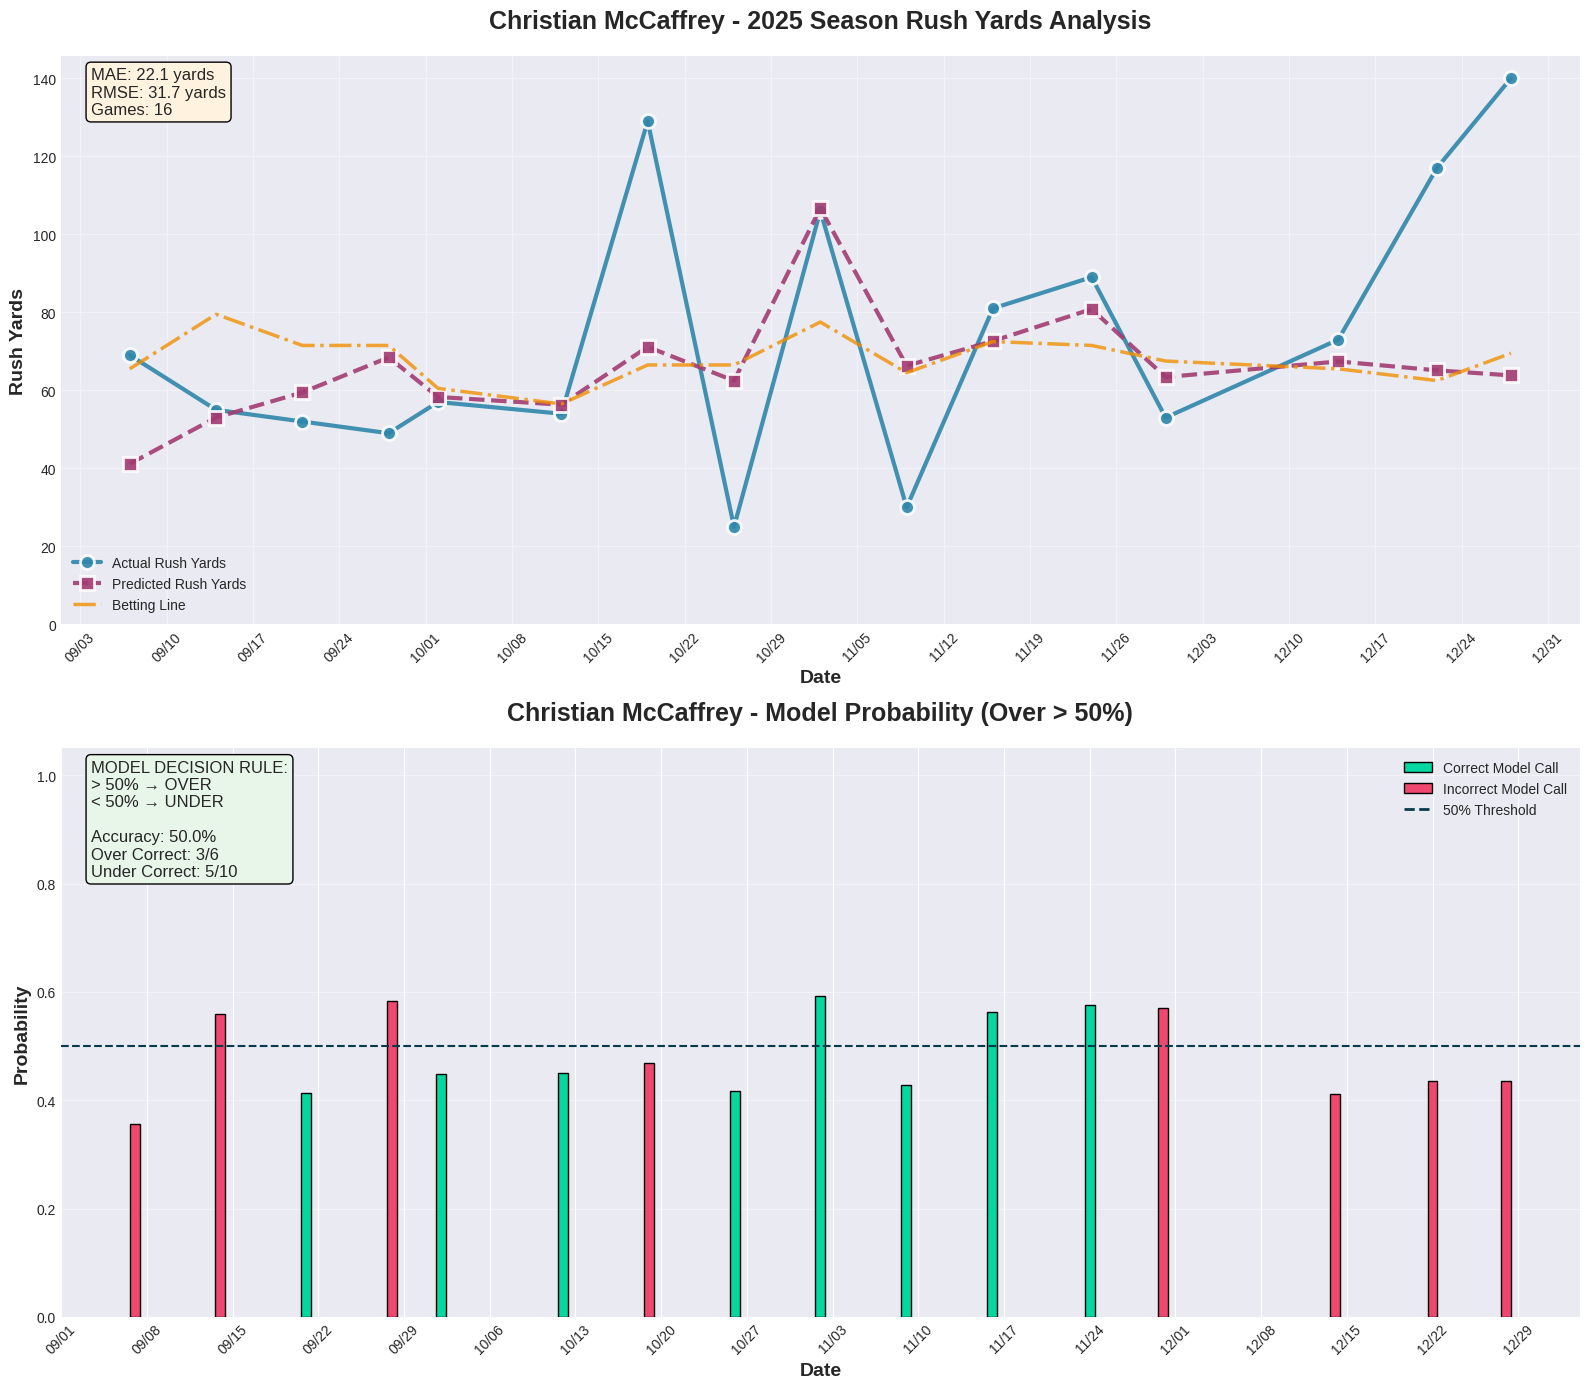


Statistics for Christian McCaffrey
MAE: 22.08
RMSE: 31.68
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 50.00%
Over Correct: 3/6
Under Correct: 5/10



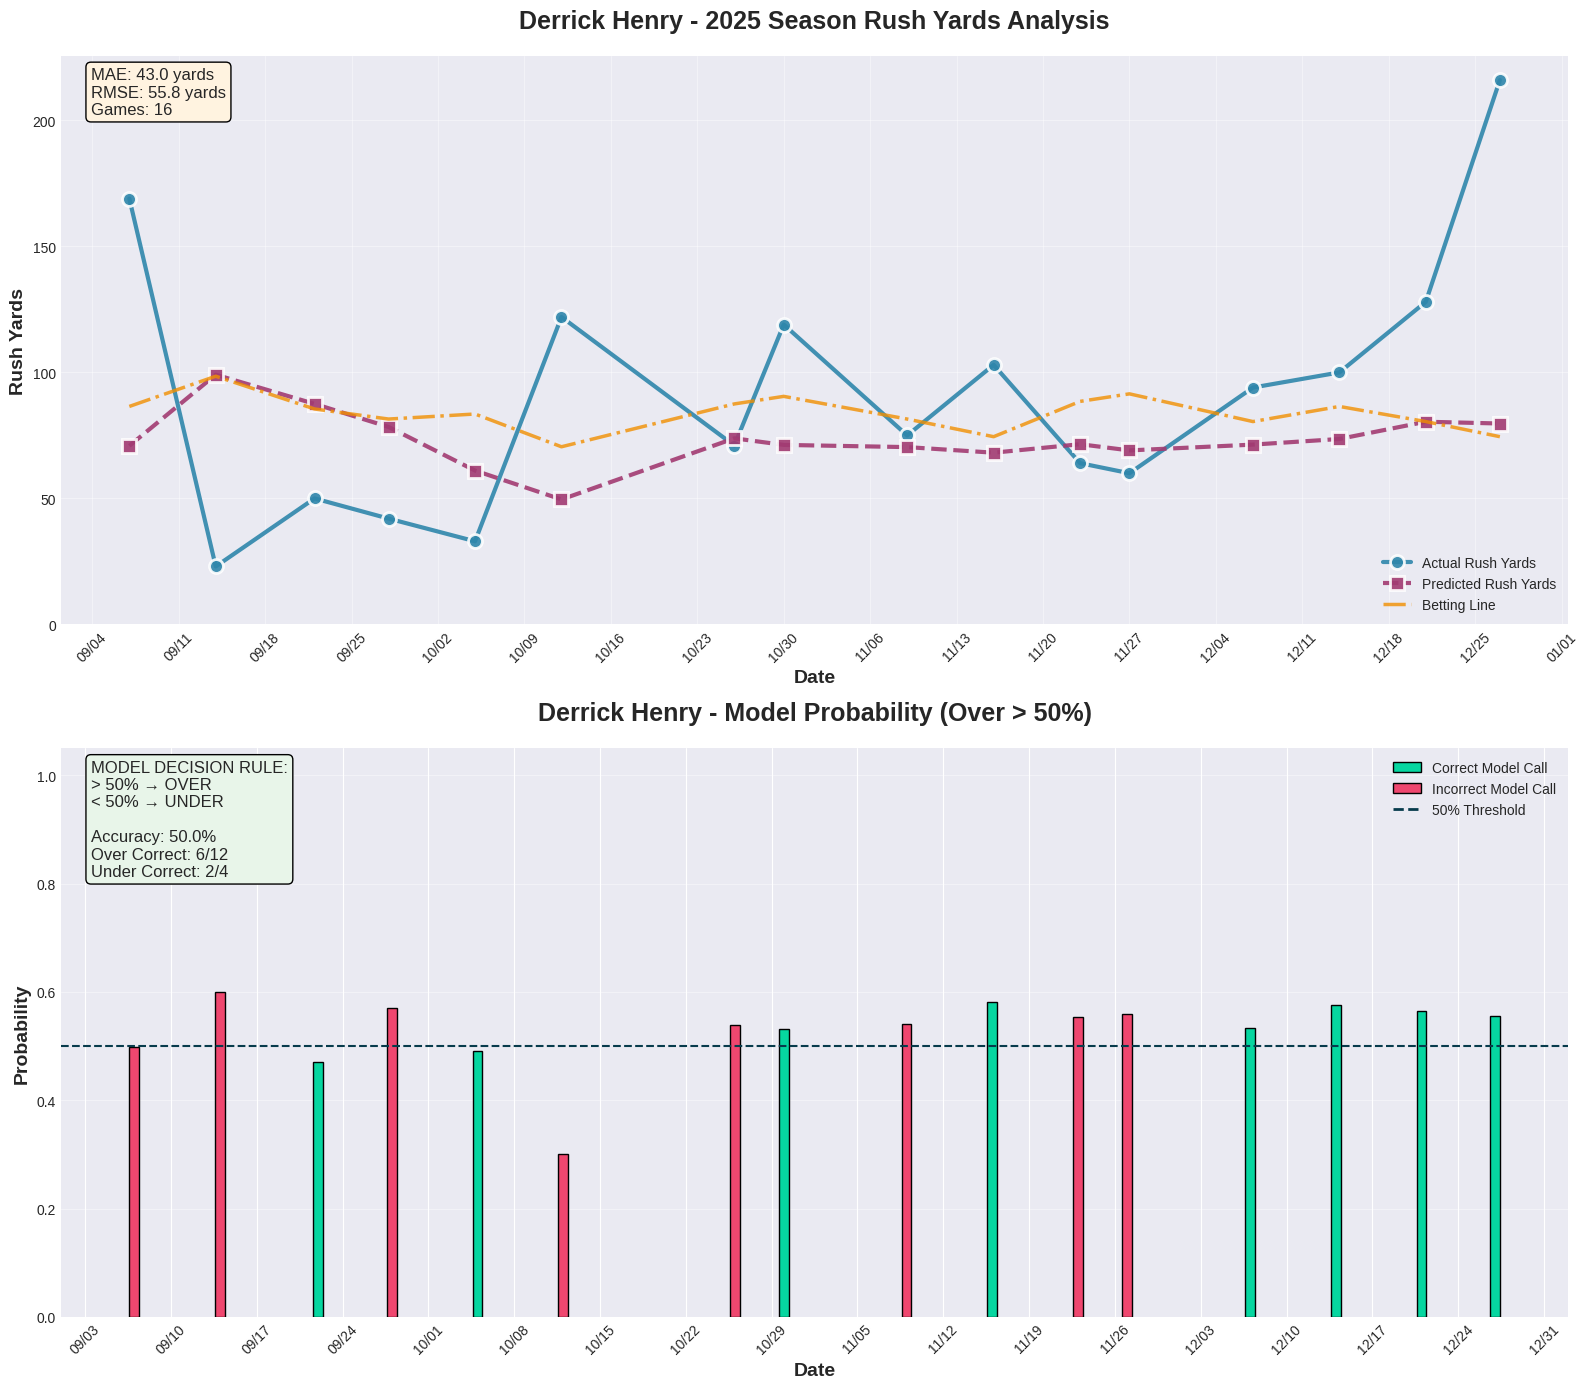


Statistics for Derrick Henry
MAE: 43.01
RMSE: 55.84
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 50.00%
Over Correct: 6/12
Under Correct: 2/4



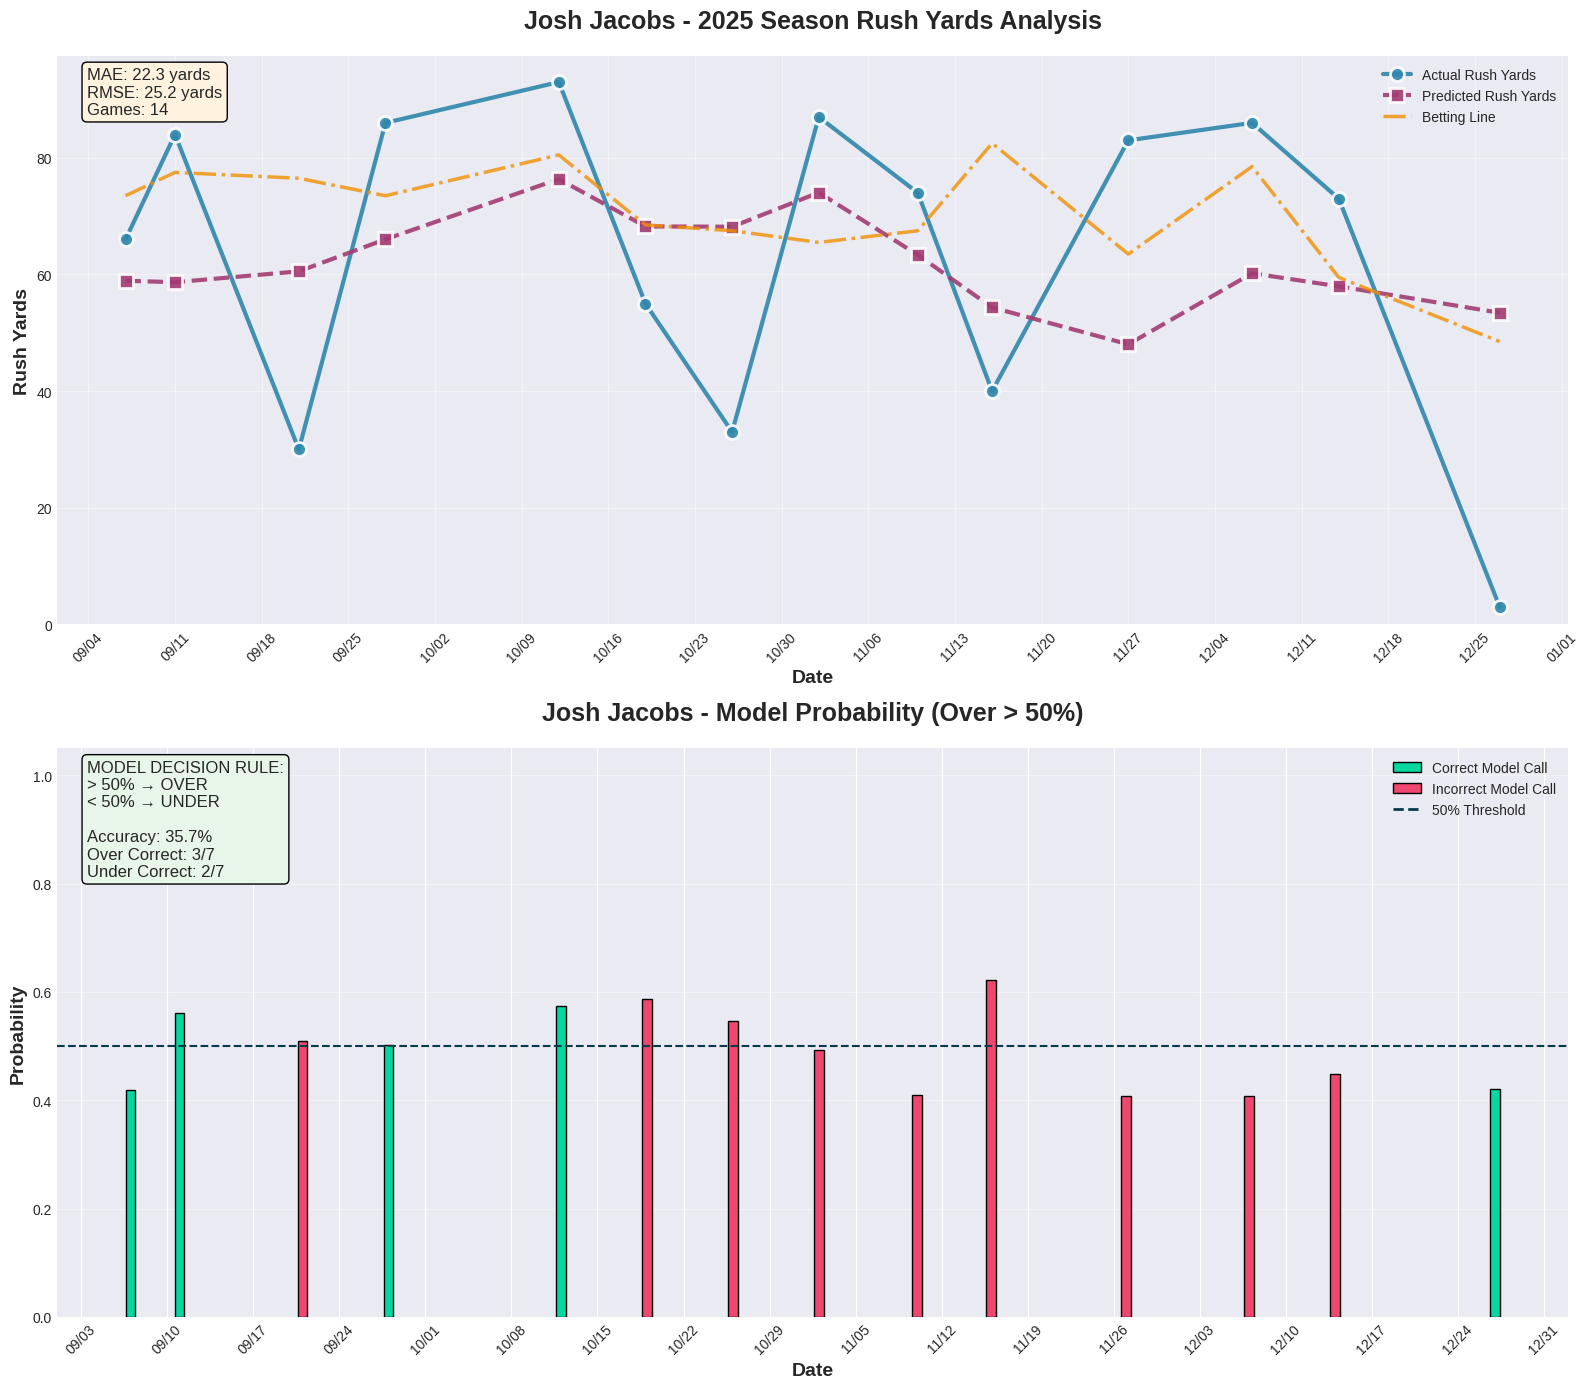


Statistics for Josh Jacobs
MAE: 22.30
RMSE: 25.16
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 35.71%
Over Correct: 3/7
Under Correct: 2/7



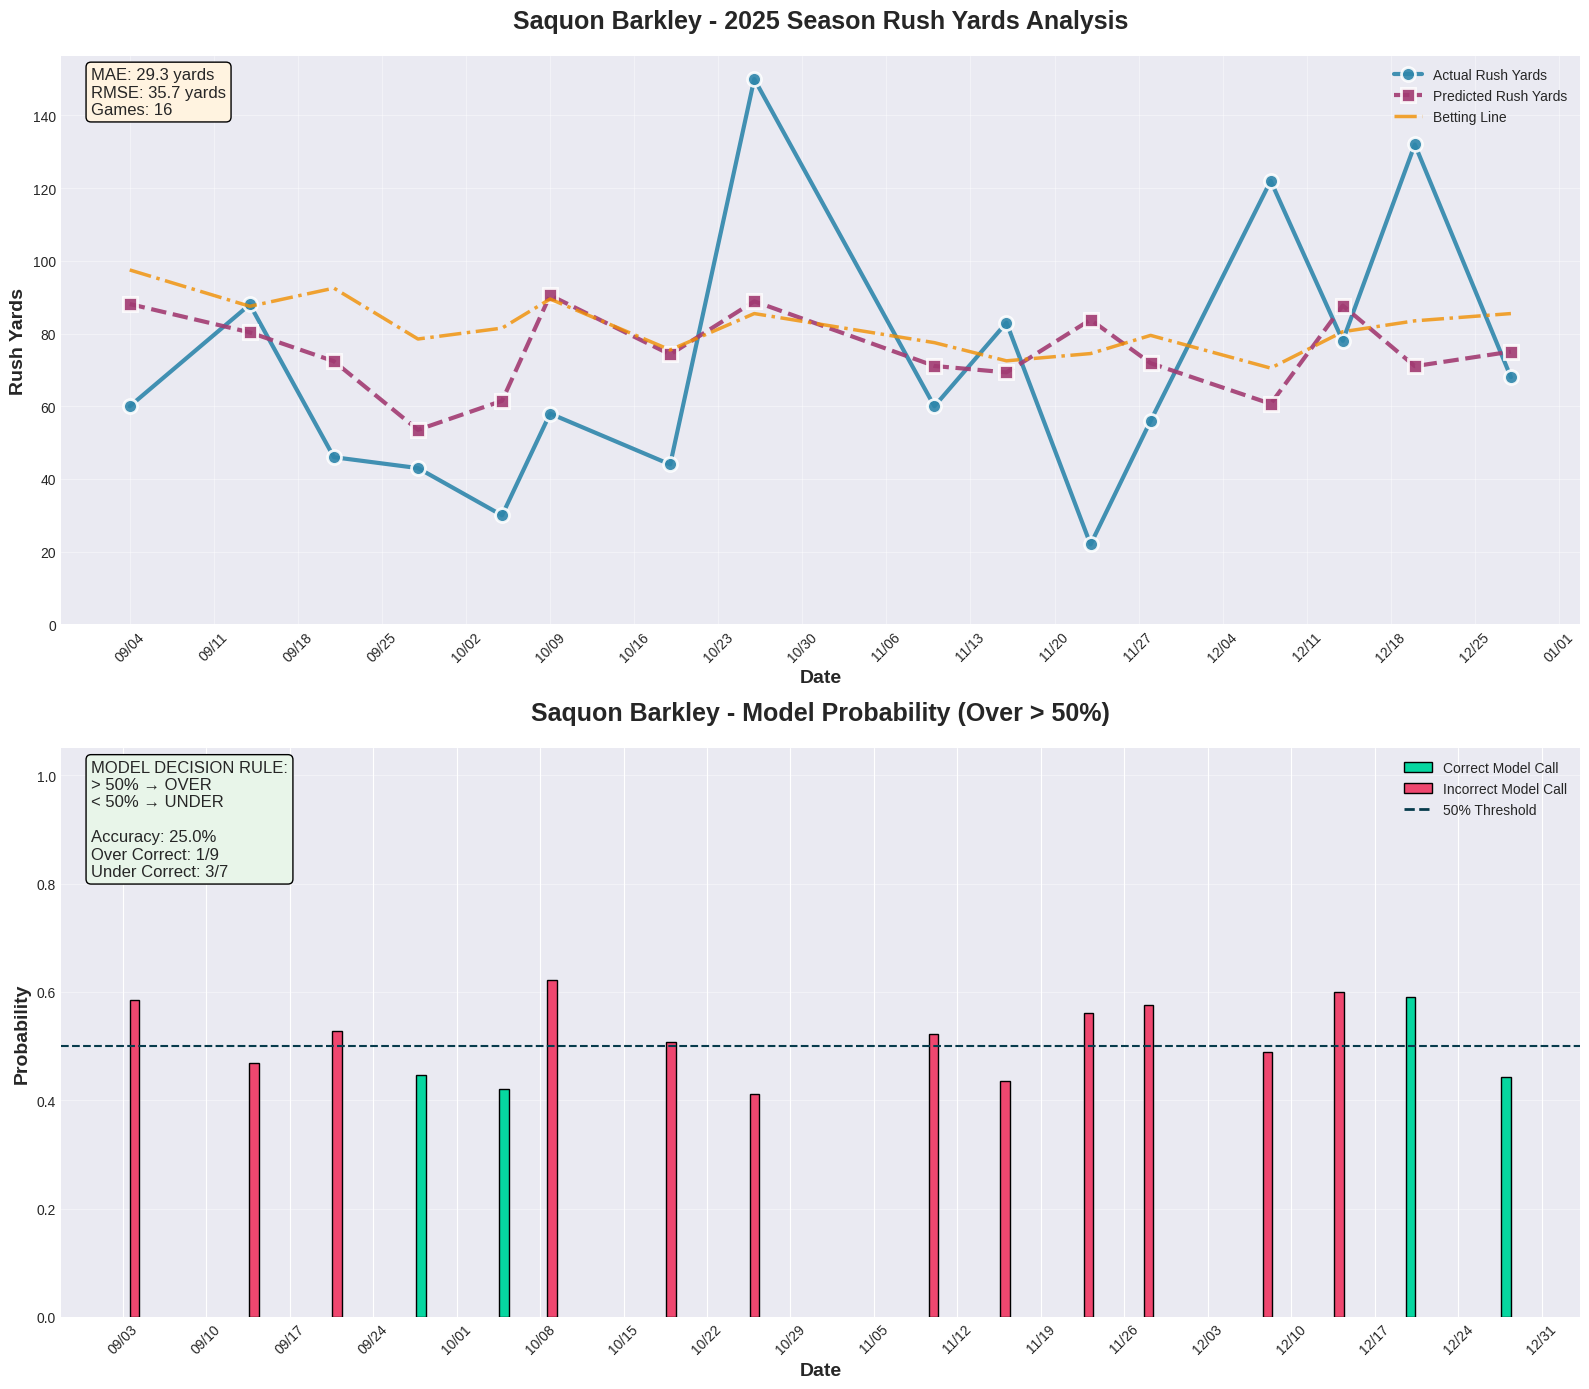


Statistics for Saquon Barkley
MAE: 29.35
RMSE: 35.67
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 25.00%
Over Correct: 1/9
Under Correct: 3/7



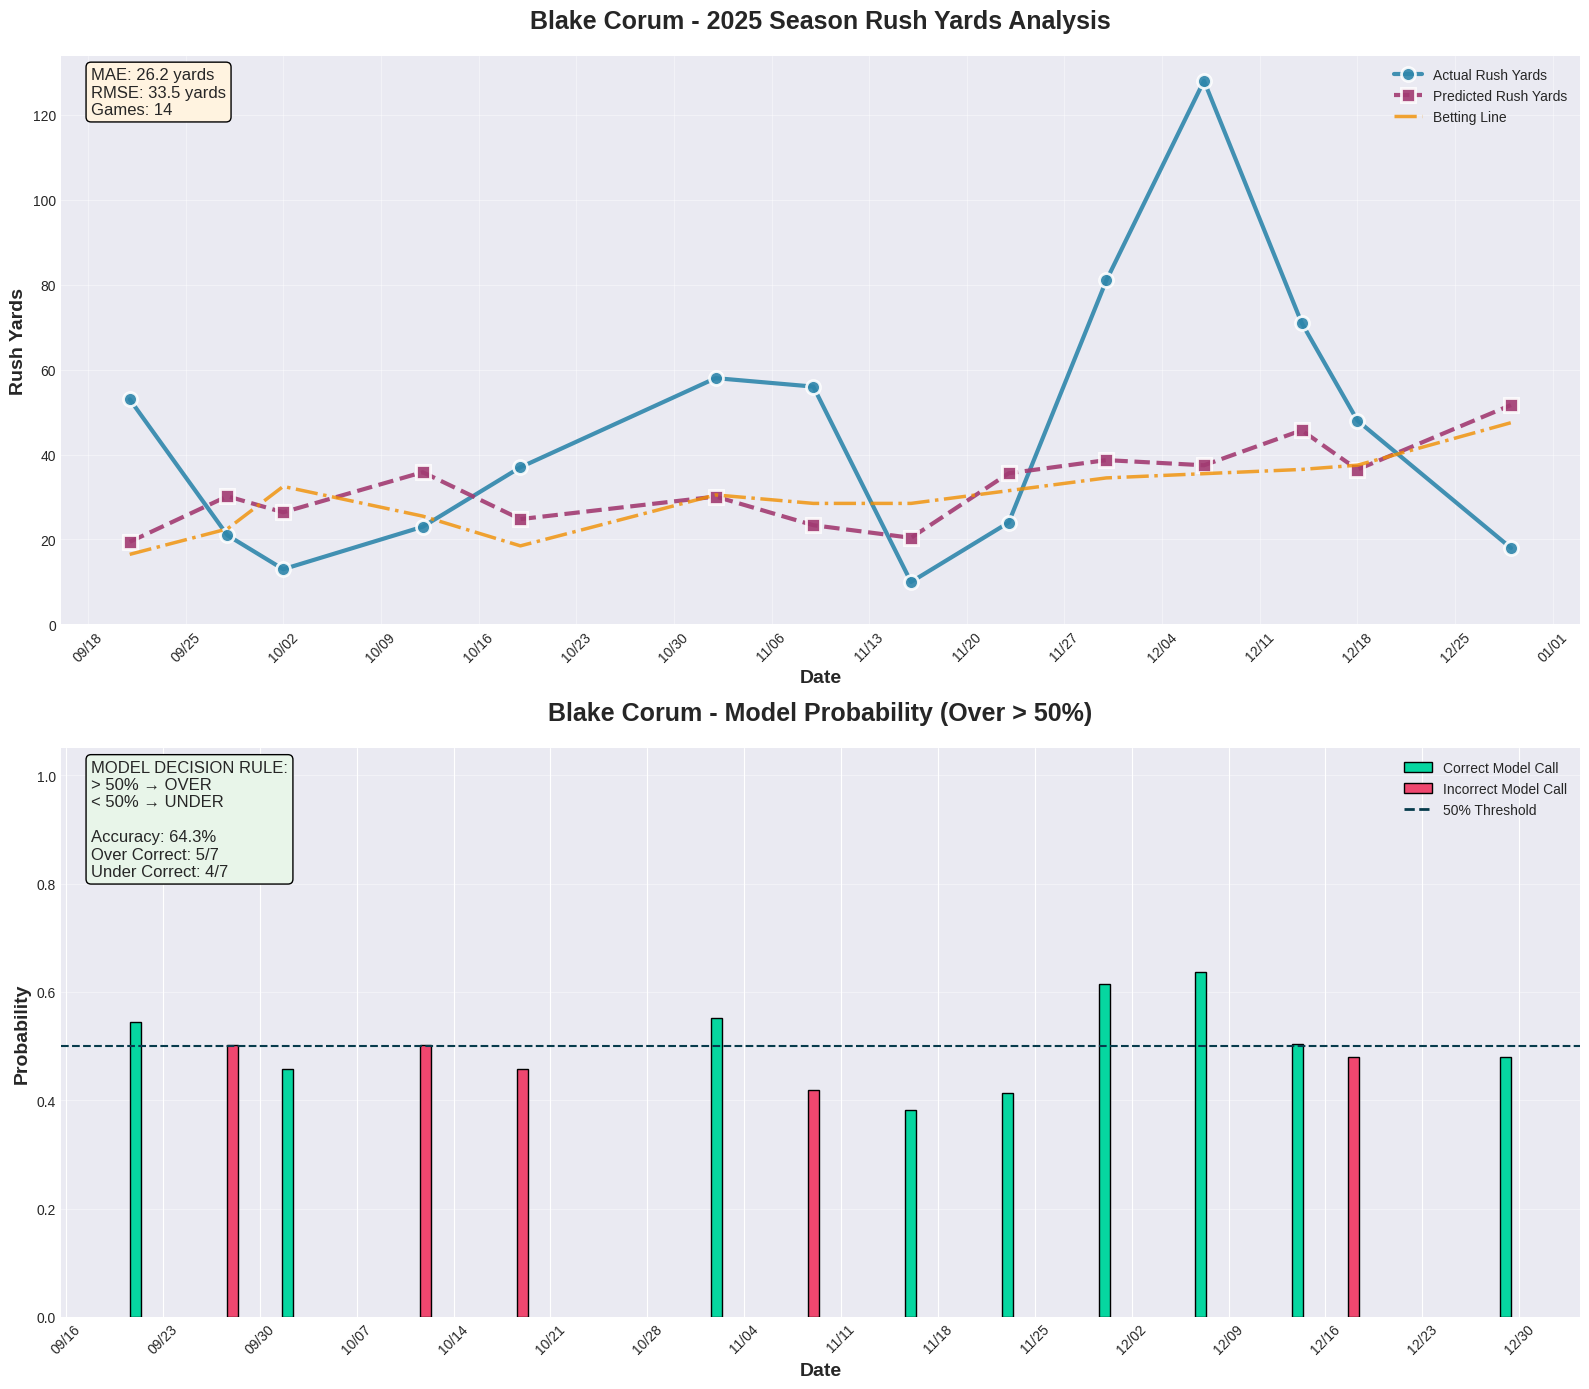


Statistics for Blake Corum
MAE: 26.21
RMSE: 33.47
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 64.29%
Over Correct: 5/7
Under Correct: 4/7



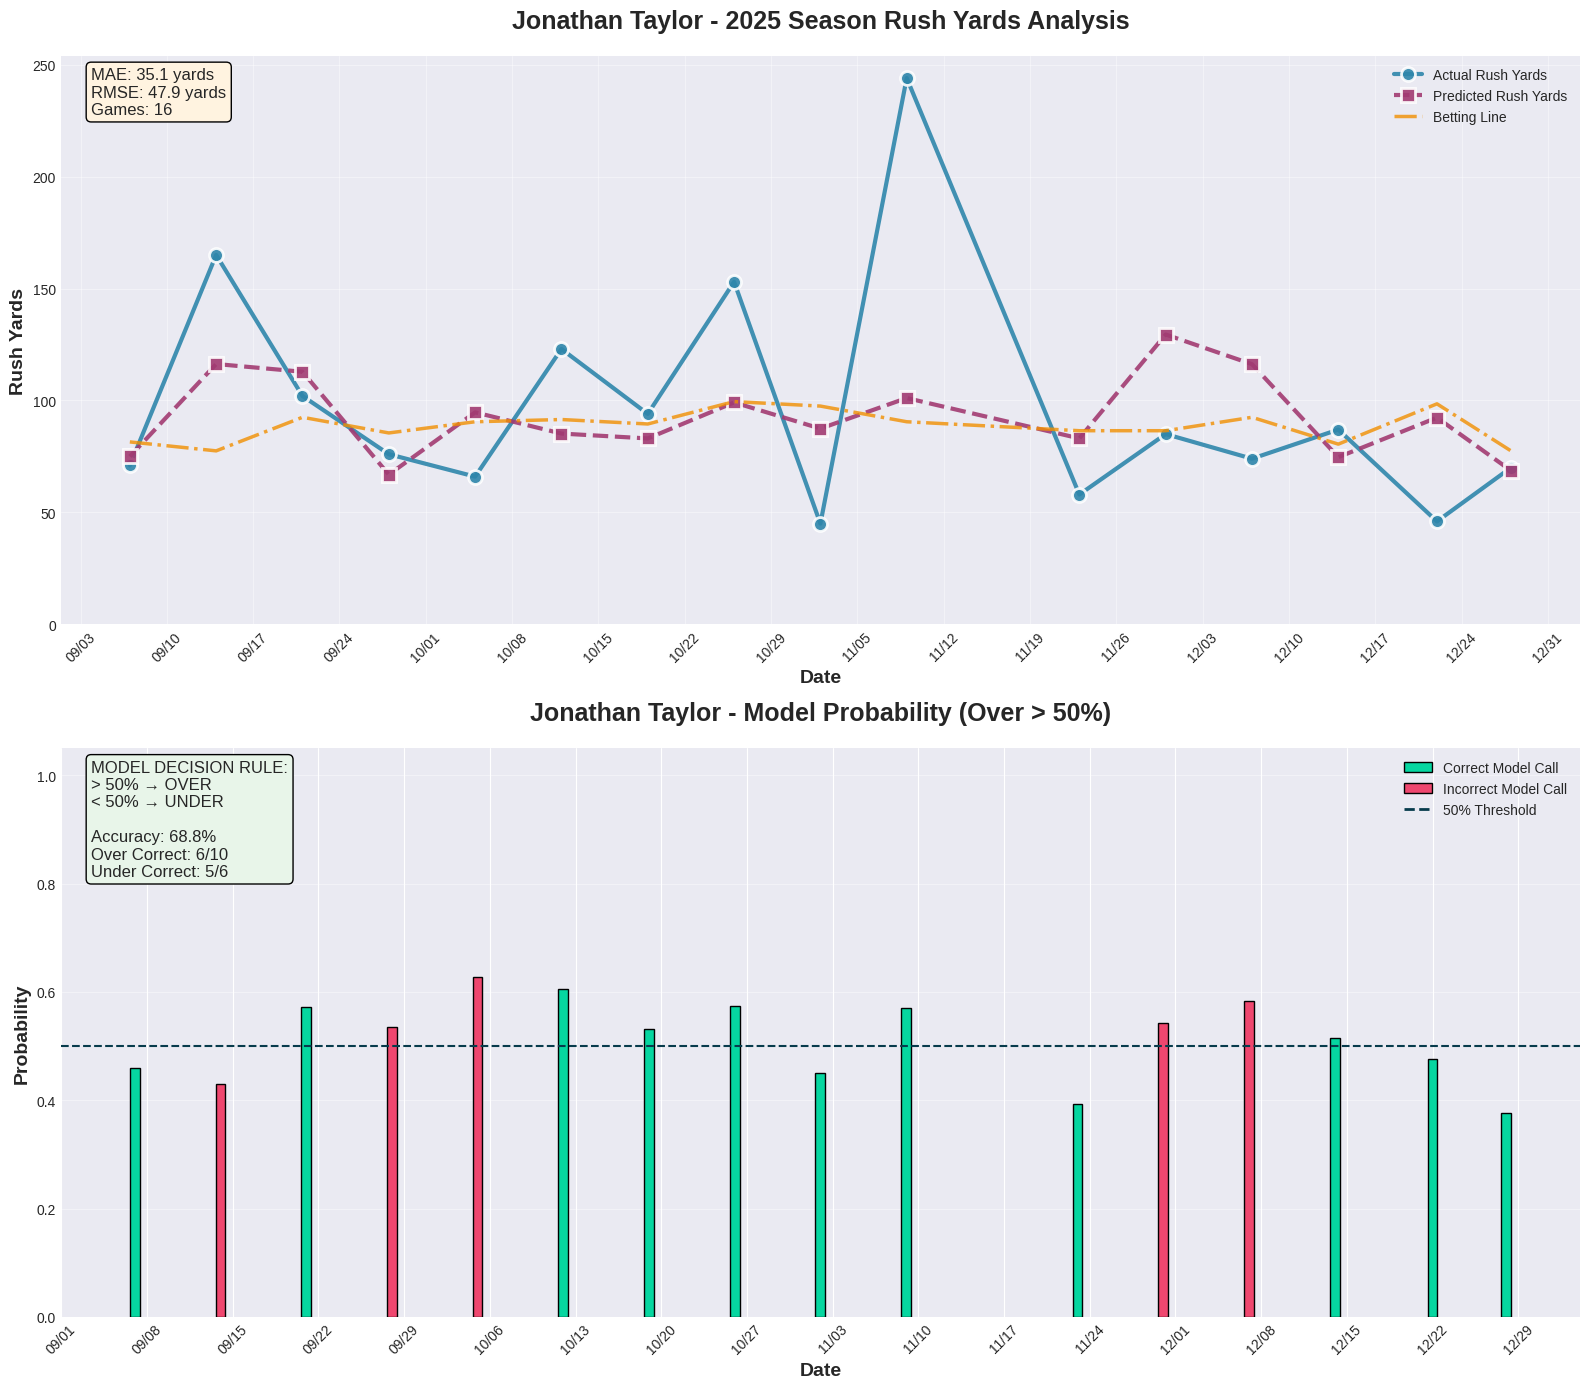


Statistics for Jonathan Taylor
MAE: 35.07
RMSE: 47.94
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 68.75%
Over Correct: 6/10
Under Correct: 5/6



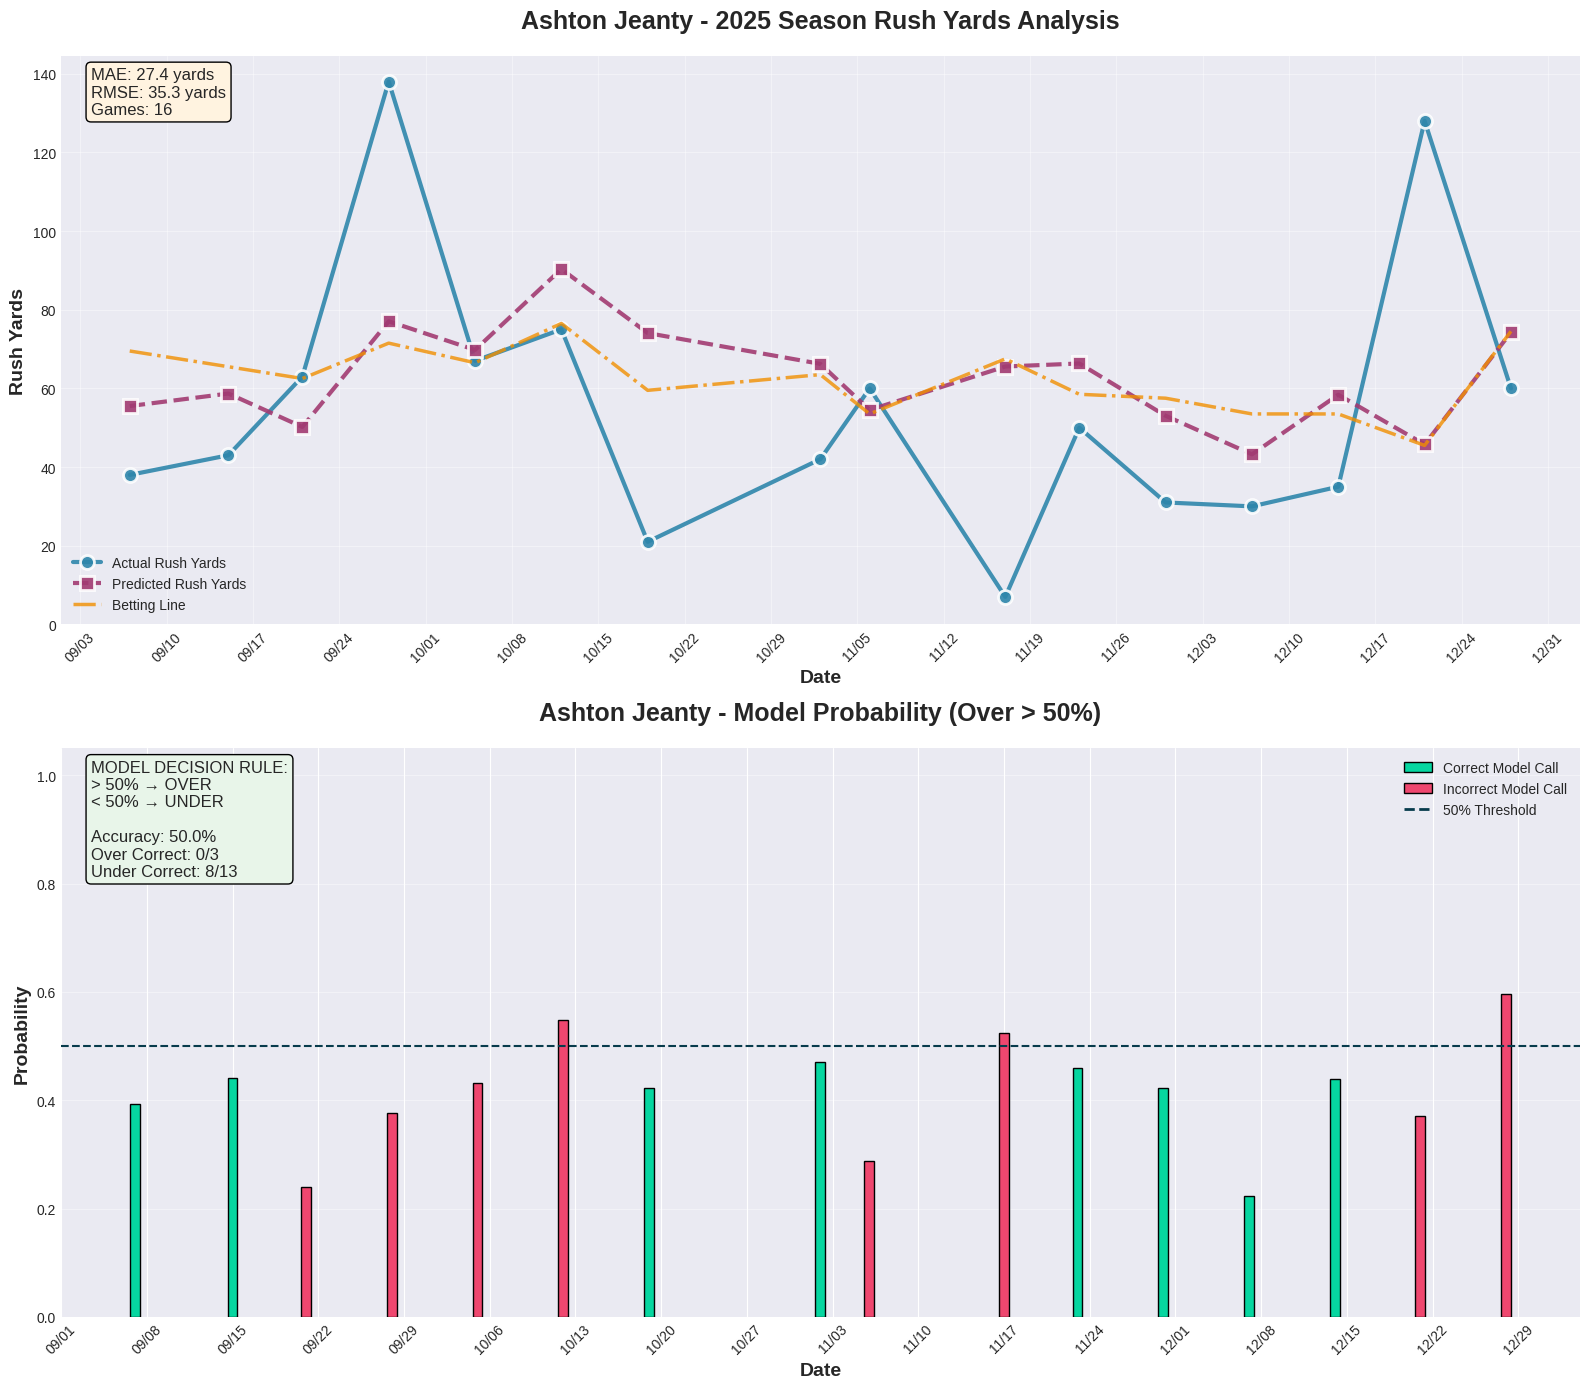


Statistics for Ashton Jeanty
MAE: 27.37
RMSE: 35.34
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 50.00%
Over Correct: 0/3
Under Correct: 8/13



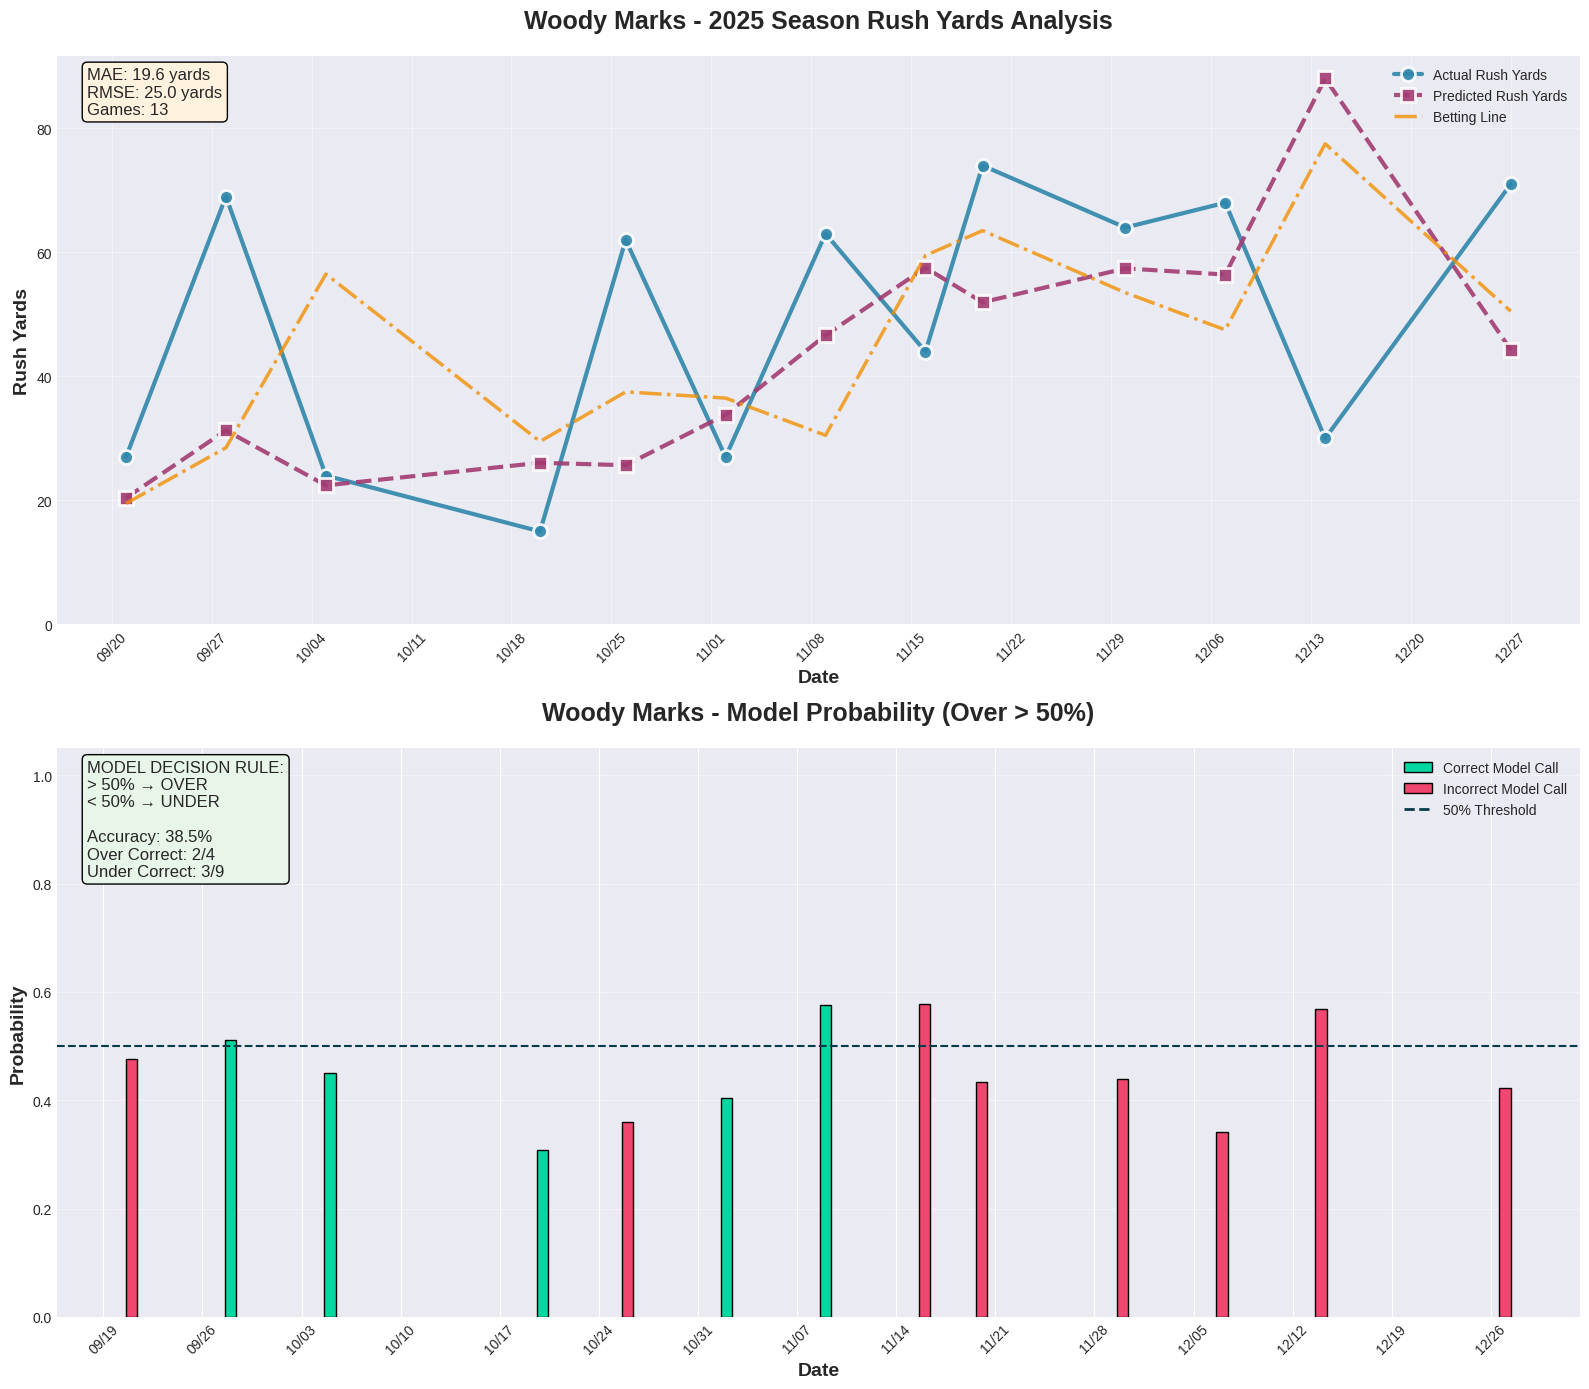


Statistics for Woody Marks
MAE: 19.61
RMSE: 25.05
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 38.46%
Over Correct: 2/4
Under Correct: 3/9



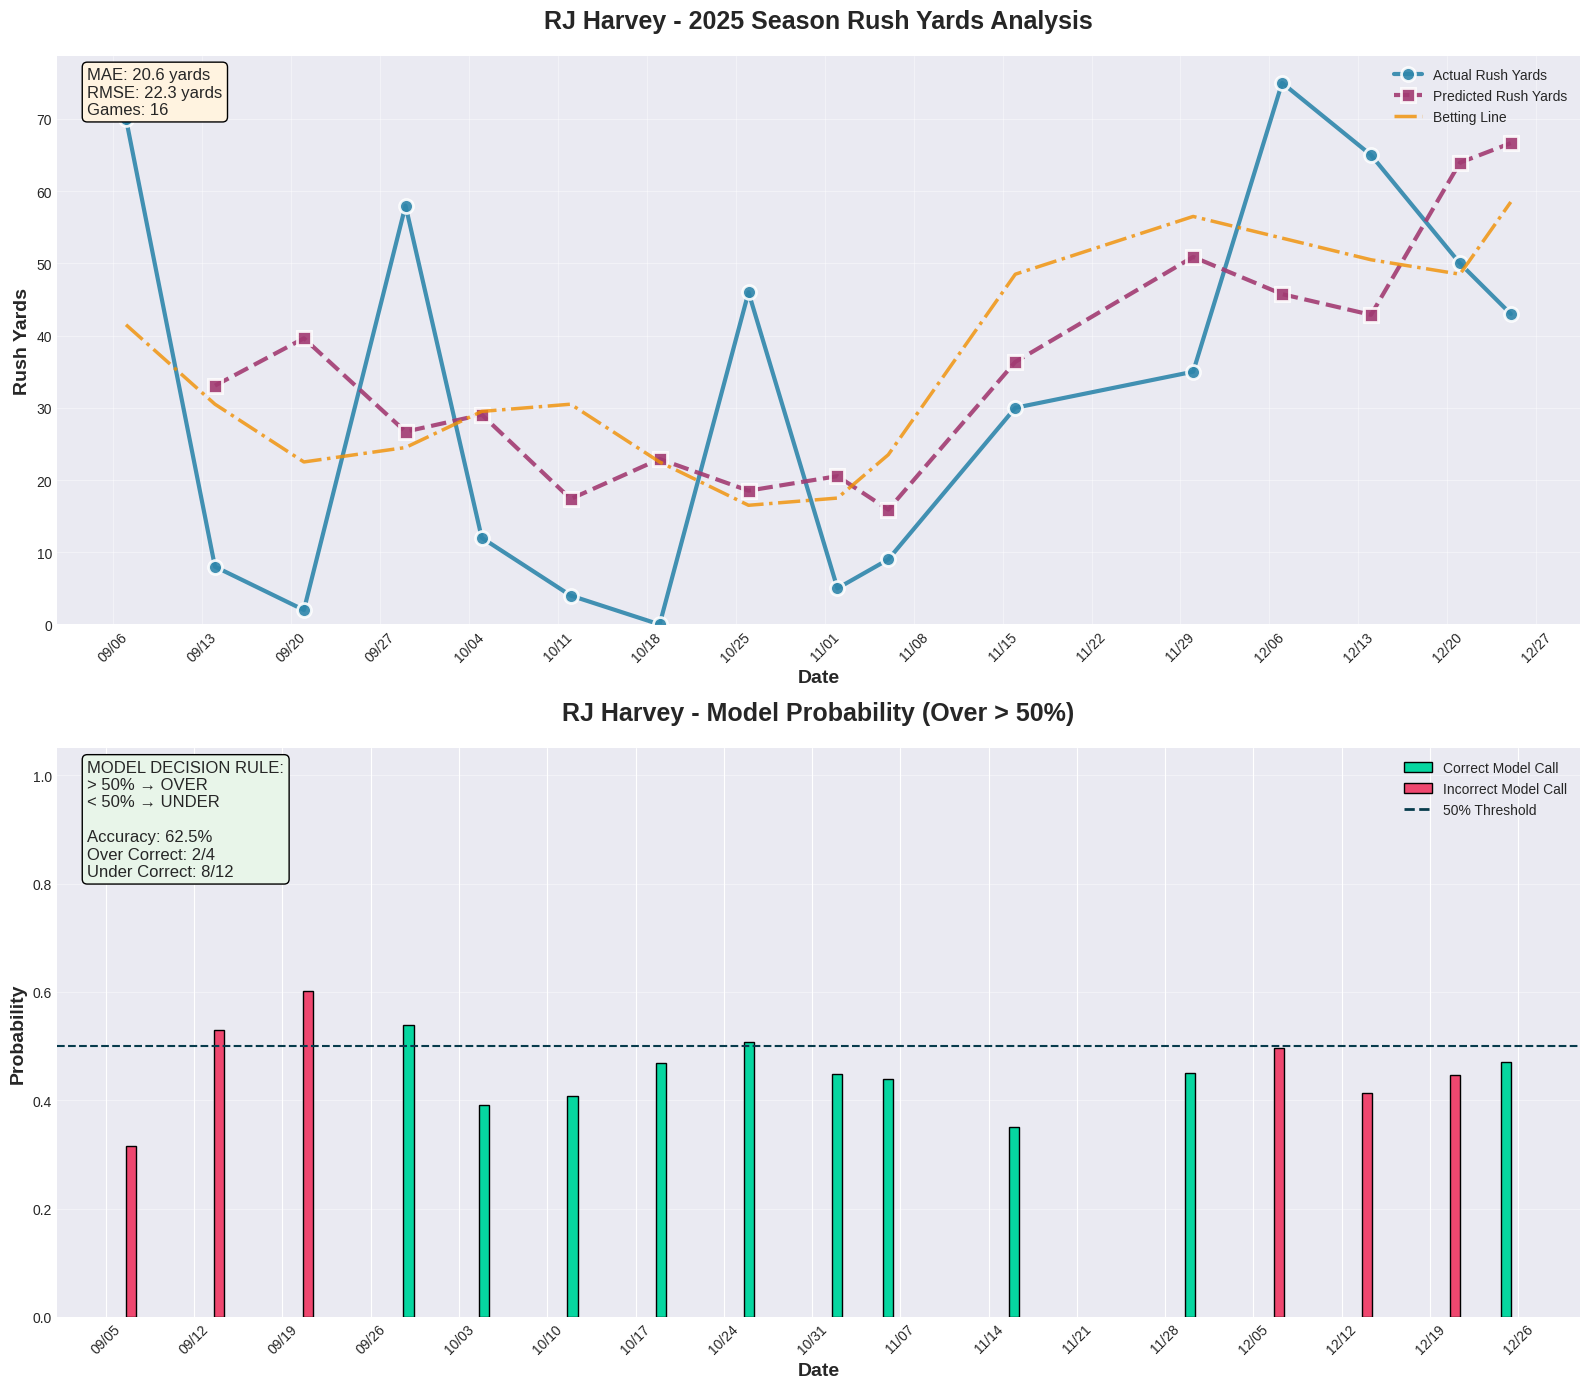


Statistics for RJ Harvey
MAE: 20.57
RMSE: 22.29
MODEL RULE: >50% = OVER, <50% = UNDER
Accuracy: 62.50%
Over Correct: 2/4
Under Correct: 8/12



In [52]:
# -- Per-player prediction visualization --
# Plots two subplots per player:
#   Subplot 1: Actual vs. predicted rush yards with the bookmaker line overlay.
#              Annotated with MAE and RMSE.
#   Subplot 2: Model probability bar chart color-coded by correct/incorrect call.
#              Annotated with accuracy, Over/Under breakdown.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.patches import Patch

def plot_player_predictions(df: pd.DataFrame, player_names: list,
                            date_col: str = 'Date') -> None:
    # Filter to 2025 season only
    df = df[df['season'] == 2025].copy()
    player_df = df[df['Player'].isin(player_names)].copy()

    if player_df.empty:
        print(f"No data found for players: {player_names}")
        return

    player_df[date_col] = pd.to_datetime(player_df[date_col])
    player_df = player_df.sort_values(date_col)

    plt.style.use('seaborn-v0_8-darkgrid')

    for player_name in player_names:
        player_data = player_df[player_df['Player'] == player_name].copy()

        if player_data.empty:
            print(f"No data for {player_name}")
            continue

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))

        # ============================================================
        # SUBPLOT 1 — Actual vs. Predicted vs. Line
        # ============================================================
        ax1.plot(player_data[date_col], player_data['Rush_yards'],
                 label='Actual Rush Yards', marker='o', linestyle='-',
                 linewidth=3, markersize=10, color='#2E86AB',
                 markeredgecolor='white', markeredgewidth=2, alpha=0.9)

        ax1.plot(player_data[date_col], player_data['predicted_rush_yards'],
                 label='Predicted Rush Yards', marker='s', linestyle='--',
                 linewidth=3, markersize=10, color='#A23B72',
                 markeredgecolor='white', markeredgewidth=2, alpha=0.9)

        if 'line' in player_data.columns:
            ax1.plot(player_data[date_col], player_data['line'],
                     label='Betting Line', linestyle='-.',
                     linewidth=2.5, color='#F18F01', alpha=0.8)

        # Compute regression error metrics for annotation
        mae  = np.mean(np.abs(player_data['predicted_rush_yards'] - player_data['Rush_yards']))
        rmse = np.sqrt(np.mean((player_data['predicted_rush_yards'] - player_data['Rush_yards']) ** 2))

        ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Rush Yards', fontsize=14, fontweight='bold')
        ax1.set_title(f'{player_name} - 2025 Season Rush Yards Analysis',
                      fontsize=18, fontweight='bold', pad=20)
        ax1.legend()
        ax1.grid(True, alpha=0.4)
        ax1.set_ylim(bottom=0)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

        ax1.text(0.02, 0.98,
                 f'MAE: {mae:.1f} yards\nRMSE: {rmse:.1f} yards\nGames: {len(player_data)}',
                 transform=ax1.transAxes, fontsize=12, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='#FFF3E0'))

        # ============================================================
        # SUBPLOT 2 — Model Over probability bars colored by outcome
        # ============================================================
        if 'hit_over' in player_data.columns:
            colors = []
            for prob, hit in zip(player_data['proba_over'], player_data['hit_over']):
                # Green = model call was correct; Red = incorrect
                if (prob < 0.5 and hit == 0) or (prob > 0.5 and hit == 1):
                    colors.append('#06D6A0')
                else:
                    colors.append('#EF476F')

            ax2.bar(player_data[date_col], player_data['proba_over'],
                    color=colors, edgecolor='black', width=0.8)

            legend_elements = [
                Patch(facecolor='#06D6A0', edgecolor='black', label='Correct Model Call'),
                Patch(facecolor='#EF476F', edgecolor='black', label='Incorrect Model Call'),
            ]
            ax2.legend(handles=legend_elements + [
                plt.Line2D([0], [0], color='#073B4C', linestyle='--',
                           linewidth=2, label='50% Threshold')
            ])
        else:
            ax2.bar(player_data[date_col], player_data['proba_over'],
                    color='#118AB2', edgecolor='black', width=0.8)

        # -- Model performance annotation --
        call_accuracy = correct_over = correct_under = over_calls = under_calls = None

        if 'hit_over' in player_data.columns:
            player_data['model_call'] = (player_data['proba_over'] > 0.5).astype(int)
            call_accuracy = (player_data['model_call'] == player_data['hit_over']).mean()
            over_calls    = (player_data['model_call'] == 1).sum()
            under_calls   = (player_data['model_call'] == 0).sum()
            correct_over  = ((player_data['model_call'] == 1) & (player_data['hit_over'] == 1)).sum()
            correct_under = ((player_data['model_call'] == 0) & (player_data['hit_over'] == 0)).sum()

        ax2.set_xlabel('Date', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Probability', fontsize=14, fontweight='bold')
        ax2.set_title(f'{player_name} - Model Probability (Over > 50%)',
                      fontsize=18, fontweight='bold', pad=20)
        ax2.set_ylim(0, 1.05)
        ax2.grid(True, axis='y', alpha=0.4)
        ax2.axhline(0.5, linestyle='--', color='#073B4C', linewidth=1.5)
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=7))
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        stats_text = "MODEL DECISION RULE:\n> 50% → OVER\n< 50% → UNDER\n\n"
        if call_accuracy is not None:
            stats_text += (
                f"Accuracy: {call_accuracy:.1%}\n"
                f"Over Correct: {correct_over}/{over_calls}\n"
                f"Under Correct: {correct_under}/{under_calls}"
            )

        ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#E8F5E9'))

        plt.tight_layout()
        plt.show()

        # -- Console summary --
        print(f"\n{'='*60}")
        print(f"Statistics for {player_name}")
        print(f"{'='*60}")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        if call_accuracy is not None:
            print("MODEL RULE: >50% = OVER, <50% = UNDER")
            print(f"Accuracy: {call_accuracy:.2%}")
            print(f"Over Correct: {correct_over}/{over_calls}")
            print(f"Under Correct: {correct_under}/{under_calls}")
        print(f"{'='*60}\n")


# -- Run per-player charts for key 2025 RBs --
plot_player_predictions(
    test_data,
    ['Christian McCaffrey', 'Derrick Henry', 'Josh Jacobs', 'Saquon Barkley', 'Blake Corum', 'Jonathan Taylor', 'Ashton Jeanty', 'Woody Marks', 'RJ Harvey']
)

In [53]:
# -- Completion marker --
print("Done plotting player predictions.")

Done plotting player predictions.
